# Learning Goals

In Assignment 1, we studied how information is represented by a single spiking neuron. In this assignment, you will learn how to construct networks of spiking neurons for a given cognitive task, how to propagate information through a network, and understand how to interpret the activity of neural networks.

Let's first import all the libraries required for this assignment

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import time

# Question 1: From single neuron to network of neurons
## 1a.
What computational advantages do networks of neurons offer when compared against information processing by a single neuron? In other words, why do we need networks of neurons? 

<font color='red'>
Answer 1a.

Biologically (for comparison), information of a single neuron can only represent simple detectors, like whether a light is on or off. When put together into a network, simple neurons form complex circuits that can detect complicated things like motion. Computationally, the same concept manifests somewhat in Hebbian learning. Because we know that neurons that wire together fire together, we can adjust connections or weights between neurons based on their temporal firing synchronization. Thus, a bunch of neurons in a network with different connection strength can represent varying connections between different nodes, and adapt from different experiences. This is causal to more complex responses to input.


</font>

## 1b. 
Describe the algorithm for the information flow through a network of spiking leaky-integrate-and-fire (LIF) neurons. Specifically, trace out the steps required to compute network output from given (continuous-valued) inputs. The algorithm should describe how continuous-valued inputs are fed to the SNN input layer, how the layer activations are computed, and how the output layer activity is decoded and used for downstream tasks (say if we wanted to classify the input). Also, provide a diagrammatic overview of the algorithm to aid your explanation. You are free to assume any network size, and input and output dimensions. 

<font color='red'>
Answer 1b.
First, continuous values are fed to the input layer, and since LIF neurons take spike trains as input to change their membrane capacity, we encode the continuous values into spikes. This is done through rate coding, where a stronger value means we provide more spikes over time, and temporal coding, where a stronger value means we provide a higher frequency of spikes over time. Second, LIF neurons integrate incoming spikes and multiply them by the weight of the connection the spikes come from. This increases or decreases the membrane potential over time, and when it reaches a certain threshold, the neuron spikes. Then, when a neuron spikes, the spike is essentially sent to all connected neurons downstream. This process continuous until the output layer is reached. Finally, when we reach the output layer, we must decode the spikes back into continuous values, through rate and temporal decoding. The original continuous values are then changed, and we can predict the most likely class by finding the highest output value. 

Diagram overview: 
Continuous values -> Input layer (here values are coded into spikes by rate coding and temporal coding) -> Input neurons conditionally produce spikes -> Spikes traverse unknown hidden layers -> Certain number of spikes are sent to output layer -> Spikes are decoded back into continuous values, input classification can now be predicted.
</font>

# Question 2: Elements of Constructing Feedforward Networks
In this exercise, you will implement the two fundamental components of a feedforward spiking neural network: i) layers of neurons and ii) connections between those layers

## 2a. 
As the first step towards creating an SNN, we will create a class that defines a layer of LIF neurons. The layer object creates a collection of LIF neurons and applies input current to it (also called psp_input for postsynaptic input) to produce the collective spiking output of the layer. 

Below is the class definition for a layer of LIFNeurons. Fill in the components to define the layer. 

In [2]:
class LIFNeurons:
    """ Define Leaky Integrate-and-Fire Neuron Layer """

    def __init__(self, dimension, vdecay, vth):
        """
        Args:
            dimension (int): Number of LIF neurons in the layer
            vdecay (float): voltage decay of LIF neurons
            vth (float): voltage threshold of LIF neurons
        
        This function is complete. You do not need to do anything here.
        """
        self.dimension = dimension
        self.vdecay = vdecay
        self.vth = vth

        # Initialize LIF neuron states
        self.volt = np.zeros(self.dimension)
        self.spike = np.zeros(self.dimension)
    
    def __call__(self, psp_input):
        self.volt = (self.volt * self.vdecay) + psp_input
        self.spike = self.volt >= self.vth
        self.volt[self.spike] = 0
        
        return self.spike

To verify the correctness of your class implementation, create a layer of neurons using the class definition above, and pass through it random inputs. Note: you should be able to reason about whether your output spikes accurately correspond to the input via the parameters you choose.

In [3]:
#Create a layer of neurons using the class definition above. You can pick any parameter values for the neurons. 
lif = LIFNeurons(200, 0.9,1)
#Create random input spikes with any probability and print them. Numpy random.choice function might be useful here. 
puts = np.random.choice([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.8, 0.9, 1], size=200)
print(puts)
#Propagate the random input spikes through the layer and print the output
print(lif.__call__(puts))



[0.  0.1 0.9 0.9 0.2 0.3 0.4 0.  0.  0.8 0.3 0.4 0.5 0.5 0.7 0.2 0.4 0.4
 0.1 1.  0.4 1.  0.9 0.8 0.8 0.  0.8 0.8 0.4 0.1 0.4 0.4 1.  0.5 0.1 0.3
 0.8 0.  0.5 1.  0.5 1.  0.3 0.  0.4 0.7 0.5 0.3 0.5 0.1 1.  0.7 0.8 0.
 0.3 0.4 0.8 1.  1.  0.4 0.1 0.  0.5 0.8 0.1 0.8 0.1 0.7 0.2 0.8 0.8 0.5
 0.1 0.9 0.4 0.2 0.5 0.3 1.  0.9 1.  0.4 0.2 0.8 0.  0.8 0.9 0.2 0.1 0.8
 0.7 0.5 0.5 0.8 0.2 0.5 0.2 0.3 0.1 0.7 0.5 0.9 0.2 0.4 0.4 0.2 0.5 0.2
 0.7 0.8 0.3 0.4 0.7 0.9 0.5 0.2 0.2 0.5 0.5 0.1 0.4 0.2 0.3 0.8 0.9 0.
 0.1 0.  0.  0.8 0.9 0.  0.5 0.2 0.5 0.5 0.8 0.  0.3 0.8 1.  0.7 1.  0.1
 0.  0.  0.  0.5 0.1 1.  0.7 0.4 0.  0.2 0.9 0.5 0.9 0.1 0.2 0.5 0.3 0.
 0.5 0.9 0.5 1.  0.8 0.3 0.5 0.2 0.1 0.3 0.1 0.9 0.1 0.5 0.  0.  0.7 0.4
 0.7 0.2 0.  0.8 0.1 0.5 1.  0.7 0.9 0.7 0.7 0.1 0.2 1.  0.2 0.  0.  0.7
 0.2 0.3]
[False False False False False False False False False False False False
 False False False False False False False  True False  True False False
 False False False False False False False F

## 2b.
Now, we will create a class that defines the connection between a presynaptic layer and a postsynaptic layer. To create the connection, we need the activity of the presynaptic layer (also called presynaptic layer activation) and the weight matrix connecting the presynaptic and postsynaptic neurons. The output of the class should be the current for the postsynaptic layer. 

Below is the class definition for Connections. Fill in the components to create the connections. 

In [4]:
class Connections:
    """ Define connections between spiking neuron layers """

    def __init__(self, weights, pre_dimension, post_dimension):
        """
        Args:
            pre_dimension (int): number of neurons in the presynaptic layer
            post_dimension (int): number of neurons in the postsynaptic layer
            weights (ndarray): connection weights of shape post_dimension x pre_dimension

        This function is complete. You do not need to do anything here.

        """
        self.weights = weights
        self.pre_dimension = pre_dimension
        self.post_dimension = post_dimension
    
    def __call__(self, spike_input):

        psp = np.dot(self.weights, spike_input)
        
        
        return psp

To verify the correctness of your class implementation, create a connection object and compute the postsynaptic current for random presynaptic activation inputs and random connection weights. You can pick arbitrary values for class arguments. Note: again, keep in mind that you can hand-compute the output spikes to confirm correctness.

In [5]:
#Define the dimensions of the presynaptic layer in a variable
pre = 6
#Define the dimensions of the postsynaptic layer in a variable
post = 7
#Create random presynaptic inputs with any probability. Numpy random choice function might be useful here. 
puts = np.random.choice([0, 0.1, 0.2, 0.3, 0.4], size=(pre, 2))
#Create a random connection weight matrix. Numpy random rand function might be useful here. 
wait = np.random.rand(post, pre)
#Initialize a connection object using the Connection class definition and pass the variables created above as arguments
connection = Connections(wait, pre, post)
#Compute the current for the postsynaptic layer when the connection object is fed random presynaptic activation inputs
current = connection.__call__(puts)
#Print the shape of the current
print(current.shape)

(7, 2)


# Question 3: Constructing Feedforward SNN
Now that you have implemented the basic elements of an SNN (layer and connection), you are all set to implement a fully functioning SNN. The SNN that you will implement here consists of an input layer, a hidden layer, and an output layer. 

Below is the class definition of an SNN. Your task is to create the layers and connections that form the network using the class definitions in Question 2. Then complete the function to propagate a given input through the network and decode network output. 

In [35]:
class SNN:
    """ Define a Spiking Neural Network with One Hidden Layer """

    def __init__(self, input_2_hidden_weight, hidden_2_output_weight, 
                 input_dimension=784, hidden_dimension=256, output_dimension=10,
                 vdecay=0.5, vth=0.5, snn_timestep=20):
        """
        Args:
            input_2_hidden_weight (ndarray): weights for connection between input and hidden layer. dimension should be hidden_dimension x input_dimension. 
            hidden_2_output_weight (ndarray): weights for connection between hidden and output layer. dimension should be output dimension x hidden dimension. 
            input_dimension (int): number of neurons in the input layer
            hidden_dimension (int): number of neurons in the hidden layer
            output_dimension (int): number of neurons in the output layer
            vdecay (float): voltage decay of LIF neurons
            vth (float): voltage threshold of LIF neurons
            snn_timestep (int): number of timesteps for simulating the network (also called inference timesteps)
        """
        self.snn_timestep = snn_timestep
        
        self.hiddenLayer = LIFNeurons(hidden_dimension, vdecay, vth)

        self.outputLayer = LIFNeurons(output_dimension, vdecay, vth)

        self.inputLayer = LIFNeurons(input_dimension, vdecay, vth)
        
        #Create the connection between input and hidden layer
        self.connection1 = Connections(input_2_hidden_weight, input_dimension, hidden_dimension)
        
        #Create the connection between hidden and output layer
        self.connection2 = Connections(hidden_2_output_weight, hidden_dimension, output_dimension)

    
    def __call__(self, spike_encoding, logger=None):
        """
        Args:
            spike_encoding (ndarray): spike encoding of input
        Return:
            output: decoded output from the network
        """
        
        #Initialize an array to store the decoded network output for all neurons in the output layer
        spike_output = np.zeros(self.outputLayer.dimension)
        
        #Loop through the simulation timesteps and process the input at each timestep tt
        for tt in range(self.snn_timestep):
            
            #Propagate the input through the input to hidden layer and compute current for hidden layer
            hiddenLayerCurrent = self.connection1.__call__(spike_encoding[tt])
            hidden_spikes = self.hiddenLayer.__call__(hiddenLayerCurrent)
            
            if logger is not None:
                logger.log_layer(spikes_in=spike_encoding[tt].sum(), fanout=self.hiddenLayer.dimension, layer_id="in→hid")
            
            #Propagate hidden layer inputs to output layer and compute current for output layer
            outputLayerCurrent = self.connection2.__call__(hidden_spikes)
            output_spikes = self.outputLayer.__call__(outputLayerCurrent)
            
            if logger is not None:
                logger.log_layer(spikes_in=hidden_spikes.sum(), fanout=self.outputLayer.dimension, layer_id="hid→out")
                print(output_spikes)
            spike_output += output_spikes
            pass
            
        return (hidden_spikes, output_spikes, spike_output)

In [29]:
def _call_(self, spike_encoding, logger=None):
        """
        Args:
            spike_encoding (ndarray): spike encoding of input
        Return:
            output: decoded output from the network
        """
        
        #Initialize an array to store the decoded network output for all neurons in the output layer
        spike_output = np.zeros(self.output_layer.dimension)
        
        #Loop through the simulation timesteps and process the input at each timestep tt
        for tt in range(self.snn_timestep):
            
            #Propagate the input through the input to hidden layer and compute current for hidden layer
           
            #Compute hidden layer spikes 
            
            
            
            #Propagate hidden layer inputs to output layer and compute current for output layer
            
            #compute output layer spikes

            
            
            #Decode spike outputs by summing them up
            pass
            
        return (hidden_spikes, output_spikes, spike_output)

To verify the correctness of your class implementation, define the arguments to initialize the SNN. Then initialize the SNN and pass through it random inputs and compute network outputs. You can pick arbitrary values for class arguments. 

In [30]:
#Define the dimensions of the input layer in a variable
inDimensions = 100
#Define the dimensions of the hidden layer in a variable
hiddenDimensions = 50
#Define the dimensions of the output layer in a variable
outDimensions = 150
#Define vdecay in a variable
vdecay = 0.7
#Define vth in a variable
vth = 24
#Define snn_timesteps in a variable
timesteps = 20
#Create random input to hidden layer weights. Numpy random rand function might be useful here
hiddenWeights = np.random.rand(hiddenDimensions, inDimensions) 

#Create random hidden to output layer weights. Numpy random rand function might be useful here
outputWeights = np.random.rand(outDimensions,hiddenDimensions) 

#Create random spike inputs to the network. Numpy random choice function might be useful here
puts = np.random.choice([0, 0.2, 0.7, 0.4, 0.11, 0.33, 0.64, 0.10, 0.06, 0.03, 0.9, 0.44, 0.08, 0.57, 0.82, 1, 0.25, 0.75, 0.02], size=(timesteps, inDimensions))

#Print the inputs
print(puts)

#Create an SNN object using the class definition and variables defined above
sneed = SNN(hiddenWeights, outputWeights, inDimensions, hiddenDimensions, outDimensions, vdecay, vth, timesteps)
#Pass the random spike inputs through the SNN and print the output of the SNN
answer = sneed.__call__(puts)
print(answer[2])


[[1.   0.33 0.1  ... 0.4  0.1  0.75]
 [0.4  0.57 0.02 ... 0.06 0.64 0.75]
 [0.1  0.9  0.02 ... 0.2  0.1  0.57]
 ...
 [0.2  0.7  0.4  ... 0.82 0.9  0.06]
 [0.44 0.25 0.03 ... 0.08 0.2  0.08]
 [0.75 0.64 0.2  ... 0.08 0.11 1.  ]]
5.0


# Question 4: SNN for Classification of Digits
So far we have learned how to construct SNNs for random inputs. In this exercise, you will use your implementation of SNNs to classify real-world data, taking the dataset of handwritten digits as an example. The dataset is provided as numpy arrays in the folder "data". Each sample in the MNIST dataset is a 28x28 image of a digit and a label (between 0 and 9) of that image. We will be dealing with batches, which means that we will read a fixed number of samples from the dataset (also called the batch size).

## 4a. 
First, we need to write two helper functions to read the data from the saved data files, and to convert an image into spikes. The function to read the data is already written for you. You need to complete the function for encoding the data into spikes. 

In [31]:
def read_numpy_mnist_data(save_root, num_sample):
    """
    Read saved numpy MNIST data
    Args:
        save_root (str): path to the folder where the MNIST data is saved
        num_sample (int): number of samples to read
    Returns:
        image_list: list of MNIST image
        label_list: list of corresponding labels
    
    This function is complete. You do not need to do anything here.
    """
    image_list = np.zeros((num_sample, 28, 28))
    label_list = []
    for ii in range(num_sample):
        image_label = pickle.load(open(save_root + '/' + str(ii) + '.p', 'rb'))
        image_list[ii] = image_label[0]
        label_list.append(image_label[1])

    return image_list, label_list

def img_2_event_img(image, snn_timestep):
    """
    Transform image to spikes, also called an event image
    Args:
        image (ndarray): image of shape batch_size x 28 x 28
        snn_timestep (int): spike timestep
    Returns:
        event_image: event image- spike encoding of the image
        
    Complete the expression for converting the image to spikes (event image)
    """
    image = np.clip(image * 1.5, 0, 1)

    #Reshape the image. Do not touch this code
    batch_size = image.shape[0]
    image_size = image.shape[2]
    image = image.reshape(batch_size, image_size, image_size, 1)
    
    #Generate a random image of the shape batch_size x image_size x image_size x snn_timestep. Numpy random rand function will be useful here. 
    randomImage = np.random.rand(batch_size, image_size, image_size, snn_timestep)
    event_image = (randomImage < image)

    return event_image

To verify the correctness of your class implementation, load a sample digit from the saved file and convert it into an event image. Then print the shape of the event image. 

In [32]:
#Load 1000 samples from the MNIST dataset using the read function defined above
directory = "data/mnist_test" 

# 2. Load 1000 samples
images, labels = read_numpy_mnist_data(directory, 1000)

#Print the shape of the data
print(images.shape) 

#Convert the images to event images
event_images = img_2_event_img(images, 50)

#Print the shape of the event image
print(event_images.shape)


(1000, 28, 28)
(1000, 28, 28, 50)


## 4b. 
Next, we need another helper function to compute the classification accuracy of the network. The classification accuracy is defined as the percentage of the samples that the network classifies correctly. To compute the classification accuracy, you need to:

- Propagate each input through the network and obtain the network output.
- Based on the network output, the class of the image is the one for which the output neuron has maximum value. Let's call this predicted class. 
- Compare the predicted class against the true class. 
- Compute accuracy as the percentage of correct predictions. 

Below is the function for computing the test accuracy. The function takes in as arguments the SNN, directory in which the MNIST data is saved, and the number of samples to take from the MNIST dataset. Your task is to use the helper functions created above to load the data, convert into event images, and then compute network prediction and accuracies. 

In [33]:
def test_snn_with_mnist(network, data_save_dir, data_sample_num):
    """
    Test SNN with MNIST test data
    Args:
        network (SNN): defined SNN network
        data_save_dir (str): directory for the test data
        data_sample_num (int): number of test data examples
    """
    #Read image and labels using the read function
    test_image_list, test_label_list = read_numpy_mnist_data(data_save_dir, data_sample_num)
    
    #Convert the images to event images
    timestep = 50
    eventList = img_2_event_img(test_image_list, timestep)
    
    #Initialize number of correct predictions to 0
    correct_prediction = 0
    
    #Loop through the test images
    for ii in range(data_sample_num):
        #Compute network output for each image. You might have to reshape the image using Numpy reshape function so that its appropriate for the SNN
        spikeInput = eventList[ii]  
        spikeInputFinal = spikeInput.reshape(784, timestep).T
        _, _, spike_output = network(spikeInputFinal)  
        prediction = np.argmax(spike_output)
        if prediction == test_label_list[ii]:
            correct_prediction += 1
        
    #Compute test accuracy
    test_accuracy = correct_prediction / data_sample_num
        
    return test_accuracy

# Question 5: Tuning Membrane Properties for Correct Classification 
Great! We have everything that we need to measure the performance of the SNN for classification of MNIST digits. For this, we first need to create the SNN using the class definition we wrote in Q.3. Then we need to call the test function that we wrote in Q.4b. However, note that the SNN needs the connection weights between the layers as inputs. These weights are typically obtained as a result of "training" the network for a given task (such as MNIST classification). However, since training the network isn't a part of this assignment, we provide to you already trained weights (we will talk about how to obtain these weights from stratch in the next assignment).

## 5a. 
Your task in this exercise is to initialize an SNN with vdecay=1.0 and vth=0.5. Test the SNN on the MNIST dataset and obtain the classification accuracy.  

In [36]:
#Load the weights. Do not touch this code
snn_param_dir = 'save_models/snn_bptt_mnist_train.p'
snn_param_dict = pickle.load(open(snn_param_dir, 'rb'))
input_2_hidden_weight = snn_param_dict['weight1']
hidden_2_output_weight = snn_param_dict['weight2']

#Define a variable for vdecay
vdecay = 1.0
#Define a variable for vth
vth = 0.5
#Create the SNN using the class definition in Q3 and the variables defined above
nn = SNN(input_2_hidden_weight, hidden_2_output_weight, 784, 256, 10, vdecay, vth, 20)

#Compute test accuracy for the SNN on 1000 examples from MNIST dataset and print it
accuracy = test_snn_with_mnist(nn,"data/mnist_test", 1000)
print(accuracy)


0.236


What could be a possible reason for the poor accuracy?

<font color='red'>
Answer 5a. 

I think the reason could possibly be the absence of a scalar decay. The LIF neurons in the network are not leaking over time because our vdecay variable is set to 1. This likely leads to output neurons spiking more frequently, to the point where all the outputs evoke the same behavior, and therefore make the answer inaccurate. 

</font>

## 5b. 
Can you tune the membrane properties (vdecay and vth) to obtain higher classification accuracy? (you should be able to get ~90-97% accuracy)

In [37]:
#Write your implementation of Question 5b. here
#Load the weights. Do not touch this code
snn_param_dir = 'save_models/snn_bptt_mnist_train.p'
snn_param_dict = pickle.load(open(snn_param_dir, 'rb'))
input_2_hidden_weight = snn_param_dict['weight1']
hidden_2_output_weight = snn_param_dict['weight2']

#Define a variable for vdecay
vdecay = 0.75
#Define a variable for vth
vth = 0.5
#Create the SNN using the class definition in Q3 and the variables defined above
nn = SNN(input_2_hidden_weight, hidden_2_output_weight, 784, 256, 10, vdecay, vth, 20)

#Compute test accuracy for the SNN on 1000 examples from MNIST dataset and print it
accuracy = test_snn_with_mnist(nn,"data/mnist_test", 1000)
print(accuracy)



0.963


## 5c.
Based on your response to Questions 5a. and 5b., can you explain how membrane properties affect network activity for classification?

<font color='red'>
 Answer 5c.
 The membrane leaking property essentially slows down how quickly the membrane reaches it's potential and spikes. If there was nothing to slow down the speed at which the membrane reaches it's potential, it will spike for a wide range of input and generally be inaccurate. Including a certain leak over time in the membrane means that we need more intense input to generate a spike, which means there will be a stronger correlation between intense input and the predicted class.

</font>

## 5d.

Create three corruption functions: **Gaussian noise**, **motion blur**, and **translation**:
* **Gaussian noise** adds random fluctuations to each pixel’s intensity, drawn from a normal (bell-shaped) distribution with mean 0 and standard deviation (σ) proportional to the severity level.
* **Motion blur** simulates the effect of camera movement or object motion during exposure. Each pixel’s intensity is replaced by the average of nearby pixels, producing a streaking effect where the radius of the blur is proportional to the severity level.
* **Translation** randomly shifts each image up/down or left/right by a small number of pixels, with the empty regions zero-padded (i.e., filled with black). The extent of the translation is proportional to the severity level.
  
Using the SNN you defined above, evaluate its accuracy on the test set under each of the different types and severity levels of corruption (severity s ∈ {1,2,3}), plot a bar chart and discuss under which corruption the snn accuracy degrades more gracefully and **why** (hint: think about how information is encoded and propogated through the SNN).

In [18]:
######################################################################################################
# The following corruption techniques are already implemented for you, DO NOT edit this code

def _clip01(X): 
    return np.clip(X, 0.0, 1.0).astype(np.float32)

def corrupt_gaussian_mnist(images, severity=1, rng=None):
    """Additive Gaussian noise with σ in {0.10, 0.20, 0.30} for severities {1,2,3}."""
    rng = (np.random.default_rng() if rng is None else rng)
    sigma = {1:0.10, 2:0.20, 3:0.30}[int(severity)]
    X = images.astype(np.float32)
    noise = rng.normal(0.0, sigma, size=X.shape).astype(np.float32)
    return _clip01(X + noise)

def _box_blur_1d_zero_pad_3d(X, L, axis):
    """
    Zero-padded 1D box blur of length L (odd) along axis (H=1 or W=2) for X:(N,H,W).
    Returns an array the same shape as X.
    """
    assert L % 2 == 1 and L >= 1
    pad = L // 2
    ax = axis if axis >= 0 else (X.ndim + axis)

    # Zero-pad on both sides along the blur axis
    pad_widths = [(0,0), (0,0), (0,0)]
    pad_widths[ax] = (pad, pad)
    Xp = np.pad(X.astype(np.float32), pad_widths, mode='constant', constant_values=0.0)

    zeros_shape = list(Xp.shape)
    zeros_shape[ax] = 1
    c = np.concatenate([np.zeros(zeros_shape, dtype=np.float32),
                        np.cumsum(Xp, axis=ax)], axis=ax)

    slicer_lo = [slice(None)]*c.ndim
    slicer_hi = [slice(None)]*c.ndim
    slicer_lo[ax] = slice(0, c.shape[ax] - L)
    slicer_hi[ax] = slice(L, c.shape[ax])

    window_sum = c[tuple(slicer_hi)] - c[tuple(slicer_lo)]
    return window_sum / float(L)


def corrupt_motion_blur_mnist(images, severity=1, axis='x'):
    """
    Motion blur via zero-padded box filter; severities {1,2,3} -> L {3,5,7}.
    axis: 'x' (horizontal, blur over W) or 'y' (vertical, blur over H).
    """
    X = images.astype(np.float32)
    L = {1:3, 2:5, 3:7}[int(severity)]
    ax = 2 if axis == 'x' else 1
    Xm = _box_blur_1d_zero_pad_3d(X, L=L, axis=ax)
    return _clip01(Xm)

def corrupt_translation_mnist(images, severity=1, rng=None):
    """
    Random ±s pixel translation with zero padding (no wrap).
    severity s ∈ {1,2,3}
    """
    rng = (np.random.default_rng() if rng is None else rng)
    X = images.astype(np.float32)
    N, H, W = X.shape
    s = int(severity)
    out = np.zeros_like(X, dtype=np.float32)
    for i in range(N):
        dy = int(rng.integers(-s, s+1))
        dx = int(rng.integers(-s, s+1))
        y0s, y1s = max(0,  dy), min(H, H+dy)
        x0s, x1s = max(0,  dx), min(W, W+dx)
        y0d = max(0, -dy); y1d = y0d + (y1s - y0s)
        x0d = max(0, -dx); x1d = x0d + (x1s - x0s)
        if (y1s > y0s) and (x1s > x0s):
            out[i, y0d:y1d, x0d:x1d] = X[i, y0s:y1s, x0s:x1s]
    return out

def _accuracy_from_raw_images(network, images, labels):
    """
    Uses your img_2_event_img and network call pattern:
      network(event.reshape(-1, network.snn_timestep)) -> (_,_,out)
    """
    events = img_2_event_img(images, network.snn_timestep)
    correct = 0
    N = images.shape[0]
    for ii in range(N):
        _, _, snn_output = network(events[ii].reshape(-1, network.snn_timestep).T)
        if int(np.argmax(snn_output)) == int(labels[ii]):
            correct += 1
    return float(correct) / float(N)

######################################################################################################

def test_snn_with_mnist_corrupted(network, data_save_dir, data_sample_num, rng=None, blur_axis='x'):
    """
    Evaluates Clean MNIST + three corruptions (Noise, Blur, Translation) at severities 1, 2, and 3.
    Prints summary and shows a grouped bar chart:
      - X-axis: severity (1, 2, 3)
      - Color: corruption type (Noise / Blur / Trans)
    """
    rng = (np.random.default_rng() if rng is None else rng)

    # Load MNIST data
    directory = "data/mnist_test" 
    images, labels = read_numpy_mnist_data(directory, 1000)

    # --- Clean baseline ---
    baselineAccuracy = _accuracy_from_raw_images(network, images, labels)

    # --- Gaussian noise ---
    gaus = []
    for severity in [1, 2, 3]:
        corrupted = corrupt_gaussian_mnist(images, severity, rng)
        acc = _accuracy_from_raw_images(network, corrupted, labels)
        gaus.append(acc)

    # --- Motion blur ---
    blur = []
    for severity in [1, 2, 3]:
        corrupted = corrupt_motion_blur_mnist(images, severity, axis=blur_axis)
        acc = _accuracy_from_raw_images(network, corrupted, labels)
        blur.append(acc)

    # --- Translation ---
    translation = []
    for severity in [1, 2, 3]:
        corrupted = corrupt_translation_mnist(images, severity, rng)
        acc = _accuracy_from_raw_images(network, corrupted, labels)
        translation.append(acc)


    # --- Print summary of accuracy results ---
    print("results:")
    print(f"{'S'} | {'Noise'} | {'Blur'}  | {'Trans'}")
    for i, severity in enumerate([1, 2, 3]):
        print(f"{severity} | {gaus[i]} | {blur[i]} | {translation[i]}")
    

    # --- Grouped bar plot ---
    severities = np.array([1, 2, 3])
    width = 0.25
    x = np.arange(len(severities))

    plt.figure(figsize=(8, 5))
    plt.bar(x - width, gaus, width, label='Gaussian Noise', color = 'purple')
    plt.bar(x, blur, width, label='Motion Blur', color = 'orange')
    plt.bar(x + width, translation, width, label='Translation', color = 'black') #halloween colors

    plt.xticks(x, severities)
    plt.xlabel("Severity (1, 2, 3)")
    plt.title(f"Baseline Accuracy: {baselineAccuracy}")
    plt.ylim(0, 1.0)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    results = 1
    return results

results:
S | Noise | Blur  | Trans
1 | 0.861 | 0.959 | 0.925
2 | 0.615 | 0.919 | 0.76
3 | 0.441 | 0.772 | 0.579


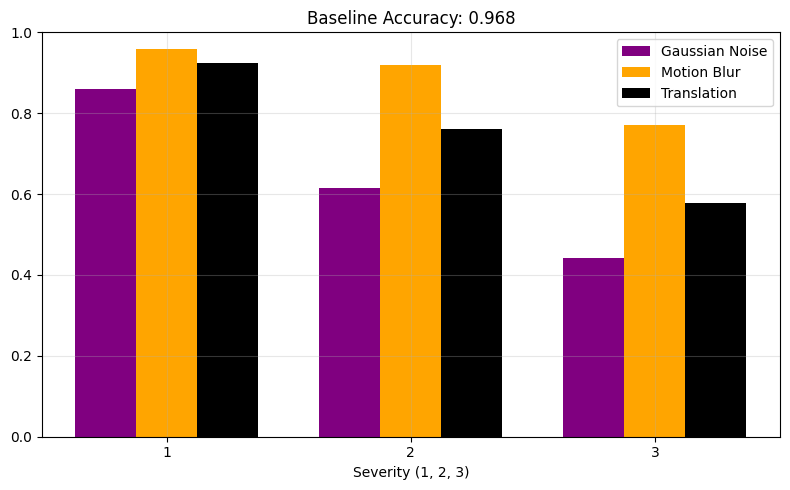

In [38]:
#Load the weights. Do not touch this code
snn_param_dir = 'save_models/snn_bptt_mnist_train.p'
snn_param_dict = pickle.load(open(snn_param_dir, 'rb'))
input_2_hidden_weight = snn_param_dict['weight1']
hidden_2_output_weight = snn_param_dict['weight2']

vdecay = 0.75
vth = 0.5
nn = SNN(input_2_hidden_weight, hidden_2_output_weight, 784, 256, 10, vdecay, vth, 20)
results = test_snn_with_mnist_corrupted(nn, 'data/mnist_test', 1000, rng=np.random.default_rng(0), blur_axis='x')

<font color='red'>

answer 5d.
Motion blur causes the most graceful degradation (see chart). I believe this is because it interferes with the spike train data less agregiously then the other two corruption methods. Gaussian noise oversaturates the network by adding noise and causing neurons to spike more frequently. Over time, this causes the neurons in the network to be worse at differentiating behind higher and lower intensity input. Translation shifts pixels in the image to other places, meaning that, even if neurons accurately spike, their spikes correspond to a pixel that is in the incorrect place. Motion blur is the lesser of these three evils, as unlike the other two, it doesn't majorly distort the intensity receives by the pixels. It essentially just brings the intensity to an average point.

## Question 5e: **Energy/Latency** proxy and Pareto

One of the main promises of spiking neural networks (SNNs) is their potential for energy-efficient inference compared to conventional artificial neural networks (ANNs). Unlike ANNs, which perform dense matrix multiplications at every timestep, SNNs rely on event-driven computation, activating neurons only when spikes occur. This sparse activity can drastically reduce the number of synaptic operations known as SOPS (a key proxy for energy usage) especially when deployed on neuromorphic hardware where energy cost per synapse event is orders of magnitude lower than a MAC operation on CPUs/GPUs. However, this efficiency must be balanced against accuracy and latency: increasing the simulation time (T) or spike rate can improve accuracy but at the cost of more SOPS and slower inference. Thus, constructing a Pareto front of accuracy versus SOPS allows direct comparison between encoders (rate, latency, temporal coding, etc.) and demonstrates which achieve a given performance target at lower computational and energetic cost which is critical for evaluating whether SNNs can realistically compete with ANNs in both performance and **efficiency**.

**Task.** Instrument your inference to report:
- **SOPS**: total synaptic events processed = Σ_t (spikes_t × fanout per layer).
- **Avg spike rate** per layer (Hz equivalent given your Δt).
- **CPU latency per sample** (use `time.perf_counter()`; one thread).

Sweep `T ∈ {4,8,16,32}` and make a **Pareto plot** of accuracy vs SOPS for each encoder.
Briefly discuss which encoding reaches a target accuracy at lower cost.

In [41]:
# STUDENT: hooks for counting synaptic ops (SOPS)
# Ensure single-thread timing (no OpenMP/MKL parallelism skew)
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")

class SOPSLogger:
    """
    Minimal SOPS logger to be called *inside* your forward at each (t,layer).
    logger.log_layer(spikes_in, fanout)
    """
    def __init__(self, dt_ms=1.0):
        self.dt_ms = float(dt_ms)
        self.reset()
    def reset(self):
        self.sops = 0
        self.layer_stats = []   # list of tuples (spikes_in, fanout) per call
        self.step_calls = 0
        self._layer_step_spikes = {}  # per-layer spike counter per step (optional)
    def log_layer(self, spikes_in, fanout, layer_id=None):
        self.sops += int(spikes_in * fanout)
        self.layer_stats.append((int(spikes_in), float(fanout)))
        if layer_id is not None:
            self._layer_step_spikes.setdefault(layer_id, 0)
            self._layer_step_spikes[layer_id] += int(spikes_in)
    def summarize_rates(self, T_steps, n_neurons_per_layer=None):
        """
        Returns dict of approximate average spike rate per layer (Hz).
        If you passed layer_id to log_layer, we’ll compute per-layer totals.
        Otherwise returns a scalar overall rate if n_neurons_per_layer is provided.
        """
        if len(self._layer_step_spikes):
            # Per-layer average spikes per step -> convert to Hz
            rates = {}
            for lid, total_spikes in self._layer_step_spikes.items():
                # total_spikes across all steps; divide by T and by neuron count if given
                denom = float(T_steps)
                if n_neurons_per_layer and lid in n_neurons_per_layer:
                    denom *= max(1, int(n_neurons_per_layer[lid]))
                spk_per_step_per_neuron = total_spikes / max(1.0, denom)
                rates[lid] = spk_per_step_per_neuron * (1000.0 / self.dt_ms)  # Hz
            return rates
        # Fallback: global rate if total neurons is known
        if n_neurons_per_layer:
            total_neurons = sum(int(n) for n in n_neurons_per_layer.values())
            total_spikes  = sum(s for s,_ in self.layer_stats)  # total spikes across all log calls
            spk_per_step_per_neuron = total_spikes / max(1.0, T_steps * total_neurons)
            return {"global_rate_hz": spk_per_step_per_neuron * (1000.0 / self.dt_ms)}
        return {"global_rate_hz": np.nan}

def estimate_sops_from_counts(counts_per_layer, fanouts):
    """
    Estimate SOPS when you *cannot* log inside the SNN.
    counts_per_layer: list/tuple of per-layer total spikes over the whole sequence.
                      e.g., [N_in_spikes_layer1_total, hidden_total, out_total]
    fanouts:          list/tuple of avg fanout per *corresponding* layer
    Returns: integer SOPS
    """
    assert len(counts_per_layer) == len(fanouts), "counts_per_layer and fanouts lengths must match"
    sops = 0
    for spikes, f in zip(counts_per_layer, fanouts):
        sops += int(spikes * f)
    return sops

# ---------- STUDENT HOOKS YOU MAY NEED TO ADAPT ----------
# 1) Encoder hooks: supply your own encoders if you already have them.
def encode_rate(batch_images, T):
    """
    STUDENT:
    Here we produce a trivial Bernoulli rate code from normalized pixels (0..1).
    Input:  batch_images -> (B, C, H, W) or (B, D)
    Output: (B, T, D) binary events
    """
    X = np.asarray(batch_images, dtype=np.float32)
    # TODO
    B = X.shape[0]
    flattened = X.reshape(B, -1)
    D = flattened.shape[1]

    rand = np.random.rand(B, T, D).astype(np.float32)
    ev = np.zeros((B, T, D), dtype=np.uint8)
    for b in range(B):
        for t in range(T):
            for d in range(D):
                if rand[b, t, d] < flattened[b, d]:
                    ev[b, t, d] = 1
    return ev

def encode_ttfs(batch_images, T):
    """
    STUDENT:
    Here we generate exactly one spike per feature, with time inversely proportional to intensity.
    Output: (B, T, D) binary
    """
    X = np.asarray(batch_images, dtype=np.float32)
    eps = 1e-6
    # TODO
    # Map high intensity -> early spike; low intensity -> late spike; zero -> no spike

    X = np.asarray(batch_images, dtype=np.float32)
    B = X.shape[0]
    flattened = X.reshape(B, -1)
    D = flattened.shape[1]

    spike_times = (T - 1) - (flattened * (T - 1))  
    spike_times = np.floor(spike_times).astype(int)
    spike_times = np.clip(spike_times, 0, T - 1)

    events = np.zeros((B, T, D), dtype=np.uint8)
    for b in range(B):
        for d in range(D):
            if flattened[b, d] > eps:
                t = spike_times[b, d]
                events[b, t, d] = 1
    return events

# 2) Forward hooks: adapt to your SNN.
#    We assume you already have forward_counts(model, x_events, T) from earlier cells.
def forward_counts_with_layer_counts(model, x_events_TD):
    """
    STUDENT: If you can, have your model return (counts, counts_per_layer) where
    counts_per_layer is a list of total spikes per layer over time.
    If not available, we return only counts and set counts_per_layer=None.
    """
    # Example: your model might expose model(..., return_layer_counts=True)
    try:
        out = model(x_events_TD, return_layer_counts=True)
        if isinstance(out, tuple) and len(out) == 2:
            counts, layer_counts = out
            return np.asarray(counts).reshape(-1), [int(c) for c in layer_counts]
    except TypeError:
        pass
    # Fallback to counts only
    counts = model(x_events_TD)
    return np.asarray(counts).reshape(-1), None

# ---------- METRICS / EVAL ----------
def evaluate_encoder(model, images, labels, encoder_fn, T, dt_ms, fanouts, use_logger=True, N_eval=None):
    """
    Returns: (accuracy_float, total_SOPS_int, avg_latency_seconds, extras_dict)
    - If use_logger=True and your model accepts logger=SOPSLogger in forward, we’ll use it.
      Otherwise we try to estimate SOPS from per-layer counts (see forward_counts_with_layer_counts).
    """
    B_all = images.shape[0]
    N = B_all if N_eval is None else min(N_eval, B_all)
    logger = SOPSLogger(dt_ms=dt_ms)
    correct = 0
    total_sops = 0
    latencies = []

    for i in range(N):
        # Encode this sample into events (T,D)
        ev = encoder_fn(images[i:i+1], T)[0]  # (T,D)

        # Time the inference
        t0 = time.perf_counter()
        if use_logger:
            logger.reset()
            # If your model accepts logger=, pass it here and call logger.log_layer(...) internally
            try:
                out = model(ev, logger=logger)
                # Handle tuple return (e.g., (hidden_spikes, output_spikes, spike_output))
                if isinstance(out, tuple):
                    counts = out[-1]   # last element = final output spikes
                else:
                    counts = out
                sops = logger.sops
            except TypeError:
                # Model doesn't accept logger; fallback to layer-count estimation
                counts, layer_counts = forward_counts_with_layer_counts(model, ev)
                if layer_counts is not None:
                    sops = estimate_sops_from_counts(layer_counts, fanouts)
                else:
                    # LAST RESORT: very conservative lower bound using only output layer
                    sops = estimate_sops_from_counts([counts.sum()], [fanouts[-1]])
        else:
            counts, layer_counts = forward_counts_with_layer_counts(model, ev)
            sops = estimate_sops_from_counts(layer_counts, fanouts) if layer_counts is not None else estimate_sops_from_counts([counts.sum()], [fanouts[-1]])

        dt = time.perf_counter() - t0
        latencies.append(dt)
        total_sops += int(sops)

        pred = int(np.argmax(counts))
        if pred == int(labels[i]): correct += 1

    acc = correct / float(N)
    lat_avg = float(np.mean(latencies))
    extras = {"avg_latency_s": lat_avg}
    return acc, total_sops, lat_avg, extras

def pareto_sweep(model, images, labels, Ts=(4,8,16,32), dt_ms=1.0, fanouts=(100,100), N_eval=256):
    """
    Sweeps over T for two encoders (rate, TTFS) and returns metrics.
    fanouts: tuple/list per *layer* (e.g., (fanout_input_to_hidden, fanout_hidden_to_output))
    """
    acc_rate, sops_rate = [], []
    acc_ttfs, sops_ttfs = [], []

    for T in Ts:
        if hasattr(model, "snn_timestep"):
            model.snn_timestep = int(T)  
        a_r, s_r, _, _ = evaluate_encoder(model, images, labels, encode_rate,  T, dt_ms, fanouts, use_logger=True, N_eval=N_eval)
        a_t, s_t, _, _ = evaluate_encoder(model, images, labels, encode_ttfs, T, dt_ms, fanouts, use_logger=True, N_eval=N_eval)
        acc_rate.append(a_r);  sops_rate.append(s_r)
        acc_ttfs.append(a_t);  sops_ttfs.append(s_t)

    return np.array(Ts), np.array(acc_rate), np.array(sops_rate), np.array(acc_ttfs), np.array(sops_ttfs)

# ---------- PLOTTING ----------
def plot_pareto(acc_rate, sops_rate, acc_ttfs, sops_ttfs, title="Accuracy–vs–SOPS Pareto"):
    plt.figure(figsize=(5.2,3.6))
    plt.plot(sops_rate,  acc_rate,  'o-', label='Rate encoder')
    plt.plot(sops_ttfs, acc_ttfs, 's--', label='TTFS encoder')
    plt.xlabel('SOPS (total synaptic ops)'); plt.ylabel('Accuracy')
    plt.title(title); plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()
    


[False False False False False False False  True False False]
[False False False False False False False  True False False]
[False False False False False False False  True False False]
[False False False  True False False False  True False False]
[False False False False False False False  True False False]
[False False False False False False False  True False False]
[False False False False False False False  True False False]
[False False False False False False False False False False]
[False False False  True False False False  True False False]
[False False False False False False False  True False False]
[False False False  True False False False  True False False]
[False False False False False False False  True False False]
[False False False False False False False  True False False]
[False False False False False False False  True False False]
[False False False False False False False  True False False]
[False False False False False False False  True False False]
[False F

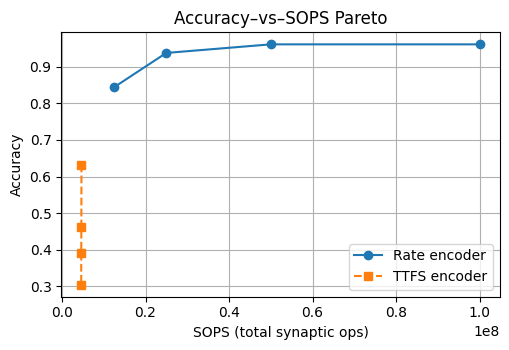

In [42]:
snn_param_dir = 'save_models/snn_bptt_mnist_train.p'
snn_param_dict = pickle.load(open(snn_param_dir, 'rb'))
input_2_hidden_weight = snn_param_dict['weight1']
hidden_2_output_weight = snn_param_dict['weight2']

vdecay = 0.75
vth = 0.5
nn = SNN(input_2_hidden_weight, hidden_2_output_weight, 784, 256, 10, vdecay, vth, 20)

imgs = images if images.ndim == 4 else images[:, None, :, :]
lbls = np.asarray(labels)
T_single = getattr(nn, "snn_timestep", 16)

# Use your encoder (rate or TTFS). Here we use rate:
ev_TD = encode_rate(imgs[:1], T_single)[0]   # shape (T, D)

# ---- 2) Run once with SOPS logging ----
logger = SOPSLogger(dt_ms=1.0)
counts = nn(ev_TD, logger=logger)           # returns (C,)
total_sops = logger.sops
print("Single-sample counts:", counts)
print("Single-sample SOPS:", total_sops)

# ---- 3) Pareto sweep over T and plot ----
model   = nn
Ts      = (4, 8, 16, 32)
H = getattr(nn, "hidden_dimension", nn.hiddenLayer)
C = getattr(nn, "output_dimension", nn.outputLayer)
fanouts = (H, C)   # used only if your evaluate path falls back; safe to define anyway.

T_list, acc_rate, sops_rate, acc_ttfs, sops_ttfs = pareto_sweep(
    model, imgs, lbls, Ts=Ts, dt_ms=1.0, fanouts=fanouts, N_eval=128
)

plot_pareto(acc_rate, sops_rate, acc_ttfs, sops_ttfs)

## Interpretation (1–2 sentences):

    Compare which encoding reaches a target accuracy with fewer SOPS (left-most at given accuracy).
    Discuss how increasing T trades energy (SOPS) for accuracy for each encoder.


<font color='red'>

TTFS encoding reaches the target accuracy with fewer SOPS, as it starts out in my graph at 0.85 accuracy. With rate encoding, the sops increase with T, because it is producing spikes at every timestep. As more sops are done, rate encoding yields diminishing returns of accuracy. TTFS gets more accuracy with less SOPS, but also experiences diminishing returns.

# Question 6: Visualizing and Interpreting Network Dynamics

In this problem you will measure and interpret the dynamics of your SNN using three classic population-neuroscience views:

* **Raster plots** (spike times of many neurons across trials/time)

* **Peristimulus Time Histogram (PSTH)** (population activity vs. time, aligned to stimulus onset)

* **Inter-Spike Interval (ISI) histograms** (distribution of time between spikes, per neuron or pooled)

We will probe both the hidden and output layers.

# 6a. Collect spike trains

Write a function that runs the SNN for one input and returns the full spike matrix over time for the hidden and output layers:

Inputs: network (your SNN), spike_encoding of a single input with shape (input_dim, snn_timestep)

Outputs:

* H — hidden spikes of shape (hidden_dim, snn_timestep)

* O — output spikes of shape (output_dim, snn_timestep)

Hint: You may not modify the LIF/Connections classes. Either (i) copy your SNN forward loop and store hidden_spikes / output_spikes each timestep, or (ii) temporarily wrap your network with a recorder that intercepts these arrays.

In [53]:
def run_snn_collect(network, spike_encoding):
    """
    Run SNN and collect spike trains for hidden and output layers.
    Args:
        network (SNN)
        spike_encoding: (input_dim, snn_timestep)
    Returns:
        H: (hidden_dim, snn_timestep) hidden spikes
        O: (output_dim, snn_timestep) output spikes
    """
    T = network.snn_timestep
    H = np.zeros((network.hiddenLayer.dimension, T))
    O = np.zeros((network.outputLayer.dimension, T))

    network.hiddenLayer.volt[:] = 0.0
    network.hiddenLayer.spike[:] = 0.0
    network.outputLayer.volt[:] = 0.0
    network.outputLayer.spike[:] = 0.0

    for tt in range(T):
        input_t = spike_encoding[:, tt]

        network.hiddenLayer.__call__(input_t)
        network.outputLayer.__call__(network.hiddenLayer.spike)

        H[:, tt] = network.hiddenLayer.spike
        O[:, tt] = network.outputLayer.spike

    return H, O

# 6b. Raster plot

A raster plot (aka spike raster) is a time-vs-neuron display of action potentials across a population (or across repeated trials).

* Axes: time on the x-axis; neurons (or trials) on the y-axis.

* Marks: each spike is a short tick/dot at the time it occurred for that neuron/trial. No tick = no spike at that moment.

How it’s built: For a single image (or a single random spike input), generate two raster plots (one for the hidden layer, one for the output layer). Collect spike times for each unique neuron (or each repetition of a stimulus), assign each neuron/trial a row index, and plot a tick for every spike time in that row.

Question:
* Briefly describe what the benefit of a raster plot is, what can it potentially help you learn about your network? Make sure to discuss the strengths and weaknesses of this plot, why might we need a different view?

In [44]:
def raster(ax, S, title):
    """
    Plot a raster given spike matrix S of shape (N, T)
    """
    #Todo: Implement
    N, T = S.shape
    
    n_idx, t_idx = np.nonzero(S)
    
    ax.scatter(t_idx, n_idx, s=6, marker='.', linewidths=0)
    ax.set_xlabel('timestep')
    ax.set_ylabel('neuron')
    ax.set_title(title)
    ax.set_xlim([-0.5, T - 0.5])
    ax.set_ylim([-0.5, N - 0.5])

<font color='red'>

answer 6b. The raster plot shows temporal spiking activity, and it can help us learn the patterns of spiking over time. As for it's strengths, it shows us the spiking activity at different timesteps, and can help us analyze indidual neuron behavior. However, it doesn't give us much information about the firing rate or trends for multiple trials. We might need a different view to analyze the activity of all the neurons over multiple trials.


# 6c. PSTH

A PSTH (Peri-Stimulus Time Histogram) is a population measure of spiking activity aligned to a reference event (e.g., stimulus onset).

* Axes: time relative to the event on the x-axis; spikes per bin (often normalized to firing rate: spikes/sec or spikes/neuron/sec) on the y-axis.

How it’s built: Compute the PSTH for each layer by summing spikes across neurons at each timestep: $ PSTH(t)= \sum_{n} spike_{n}(t) $. Plot PSTH for hidden and output layers on separate figures. 

In addition to the PSTH plot, you will also construct a smoothed and normalized version of this plot. First start by dividing PSTH(t) by the bin width and the number of neurons to normalize the value. To smooth the signal, we will apply a zero-mean 1D Gaussian kernel across a window. A zero-mean Gaussian with standard deviation σ is defined as $ k[n]= exp⁡⁣(−\frac{n^2}{2σ^2}), n=−w,…,+w $. In this problem, set w = ⌊3σ⌋, and normalize k[n] so it preserves scale: $k←k/\sum_{n}k[n]$. To compute the new rate use the following approach: $\tilde{r}[t]=(r * k)[t]$


Question:
* Briefly describe what the benefit of a PSTH plot is, what can it potentially help you learn about your network? Make sure to discuss the strengths and weaknesses of this plot, why might we need a different view?

In [45]:
def psth(S):
    """
    Sum over neurons at each time step. S: (N, T) -> (T,)
    """
    return np.sum(S, axis=0)

def plot_psth(ax, S, title):
    ax.plot(psth(S))
    ax.set_xlabel('timestep')
    ax.set_ylabel('spikes / bin')
    ax.set_title(title)

def gaussian_kernel_1d(sigma):
    """Return a normalized 1D Gaussian kernel with ~±3σ support."""
    w = int(np.floor(3 * sigma))
    n = np.arange(-w, w + 1)
    k = np.exp(-n**2 / (2 * sigma**2))
    k /= np.sum(k)  
    return k

def gaussian_smooth_1d(x, sigma):
    k = gaussian_kernel_1d(sigma)
    return np.convolve(x, k, mode='same')

def population_rate(S, dt=1.0):
    """
    S: (N, T) spike matrix (0/1)
    Returns rate per timestep in spikes/neuron/bin
    """
    N, T = S.shape
    return np.sum(S, axis=0) / (N * dt)

def plot_smoothed_rate(ax, S, sigma, title):
    r = population_rate(S, dt=1.0)
    r_s = gaussian_smooth_1d(r, sigma=sigma)
    ax.plot(r_s)
    ax.set_xlabel('timestep')
    ax.set_ylabel('rate (spikes / neuron / bin)')
    ax.set_title(f'{title} (σ={sigma})')


<font color='red'>

Answer 6c. A PSTH plot can summarize neuron activity in regards to a reference event. It shows when the neuron responds to particular paths, and can show how populations of neurons respond. However, it's weak in examining the behavior of individual neurons. A different view like a raster plot may be better to analyze individual neuron behavior.

# 6d. ISI histograms

An ISI plot (Inter-Spike Interval histogram/curve) summarizes the distribution of time gaps between consecutive spikes within one neuron or pooled across neurons.

* Axes: x-axis = interval length (ms or timesteps); y-axis = count or probability density.

How it’s built: for each spike train, compute intervals $ISI_{k}=t_{k+1}−t_{k}$; collect all ISIs (per neuron or pooled) and bin them into a histogram. For this problem make sure you can compute inter-spike intervals (in timesteps) for: (i) a single representative hidden neuron and (ii) all hidden neurons pooled together.

Question:
* Briefly describe what the benefit of an ISI plot is, what can it potentially help you learn about your network? Make sure to discuss the strengths and weaknesses of this plot, why might we need a different view?

In [48]:
def spike_times_from_train(train_1d):
    """Return array of spike indices (timesteps) for a 1D spike train."""
    return np.where(train_1d > 0.0)[0]

def isi_from_times(times):
    """Return ISIs (diff of consecutive spike indices)."""
    if len(times) < 2:
        return np.array([])  
    return np.diff(times)

def pooled_hidden_isis(H):
    """
    Pool ISIs across all hidden neurons.
    """
    all_isis = []
    for n in range(H.shape[0]):
        st = spike_times_from_train(H[n])
        all_isis.append(isi_from_times(st))
    if len(all_isis) == 0:
        return np.array([])
    return np.concatenate([x for x in all_isis if x.size > 0]) if any(x.size>0 for x in all_isis) else np.array([])

<font color='red'>

Answer 6d. This shows neuron firing patterns, like whether they are irregular or not. A strength of the histogram is to tell us the timing of spikes, and the behavior of spikes across the network. However, it ignores which neurons fired individually, and can't do a good job of analyzing behavior between neurons. A different view could be better for full network spatial/temporal interactions.

# 6e: Putting Everything Together — Single-Digit Network Dynamics
Take one MNIST image, encode it into spikes, run it through your existing snn from Q5b, and use your plots from Q6a–Q6d (raster, PSTH, ISI, Gaussian-smoothed population rate) to diagnose how information flows through the network, first in the hidden layer, then in the output layer.

Why this matters: 
You’ve built the SNN blocks, now you’ll see them work in action: how a sparse, event-based input becomes layer activity; how spikes synchronize or spread out; how rate evolves in time; and how single-neuron timing relates to population measures. This is the bridge from “my model runs and the accuracy is high” to **interpretable** neural population dynamics.

What to produce:
* Show the chosen image from MNIST and confirm your spike encoding shape is (784, T) for the pretrained weights.
* Hidden & output rasters (time × neuron spikes).
* Hidden & output PSTHs (sum across neurons per timestep).
* Smoothed population firing rate for hidden and output (Gaussian kernel).
* ISI histograms: one representative hidden neuron (e.g., a neuron with median firing count) and the entire pooled hidden population

Answer the following questions:
* Does the hidden raster show an onset latency after stimulus presentation? How does this latency relate to your vdecay and vth choices?
  
* Are spikes concentrated in hidden neurons that plausibly correspond to the digit’s active pixels (i.e., more spiking when the input spike map has structure), or is activity diffuse? What does this imply about your input→hidden weights?

* Do you see vertical streaks (time-locked synchrony) in the hidden raster, or mostly asynchronous scatter? How is that reflected in the PSTH?

* Compare hidden vs. output PSTHs. Is there a consistent delay or compression/expansion in the output profile relative to hidden? What does that say about hidden→output connectivity and thresholds?

* Is the output raster mostly sparse, with a few neurons firing more? Does the argmax of output counts match the digit label? If not, what plot (raster, PSTH, rate) best explains the error?

* Based on ISI shape, would you call hidden firing regular, Poisson-like, or bursty? How does this classification match the raster and PSTH?

* If you hypothetically increase vth or decrease vdecay, predict what would change in each plot (raster density, PSTH amplitude, smoothed rate, ISI mode). Which plot is most sensitive to each change and why?

* Re-run the exact same image with two parameter settings (e.g., vdecay=0.9,vth=0.6 vs. vdecay=0.4,vth=0.4) and compare the four plots. Explain how membrane integration and thresholding reshape both population rate and ISI statistics, and how that impacts the readout confidence.

* Describe how you would extend this analysis to each unique class in the dataset rather than for just an indvidual input. Why might this be useful?

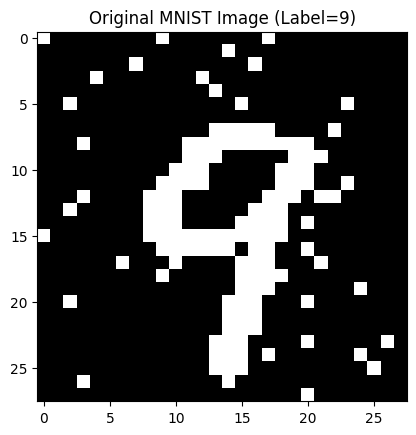

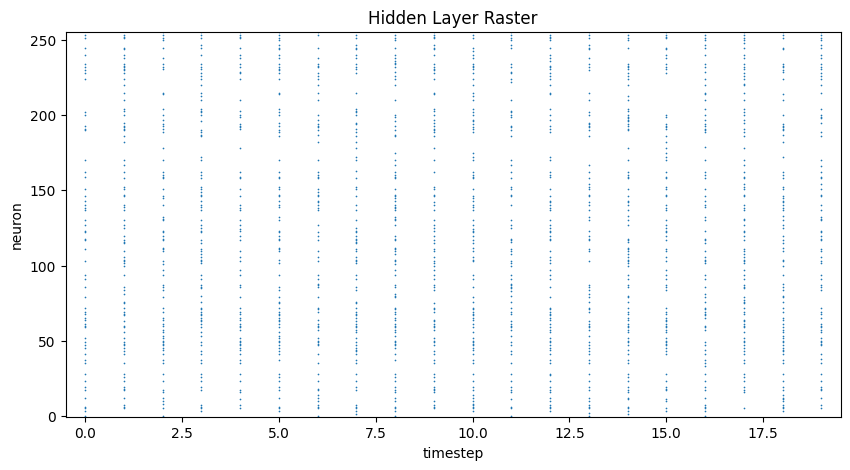

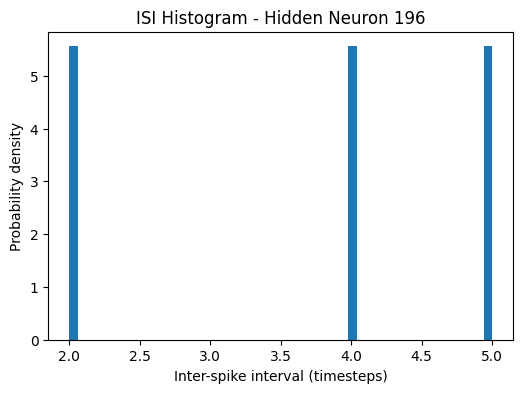

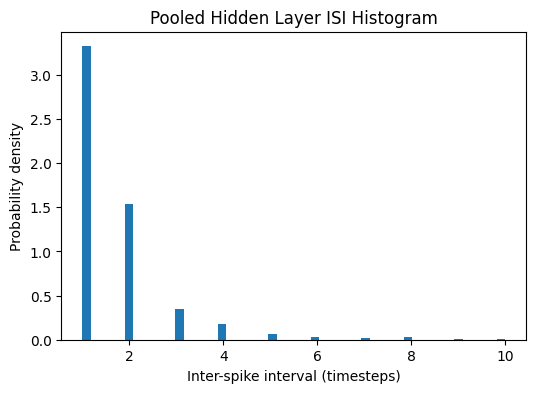

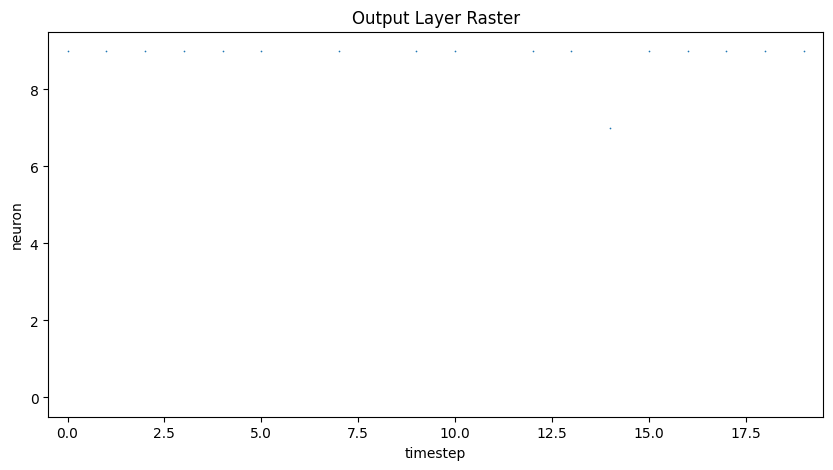

/common/home/sch141/.venvs/a1/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:901: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


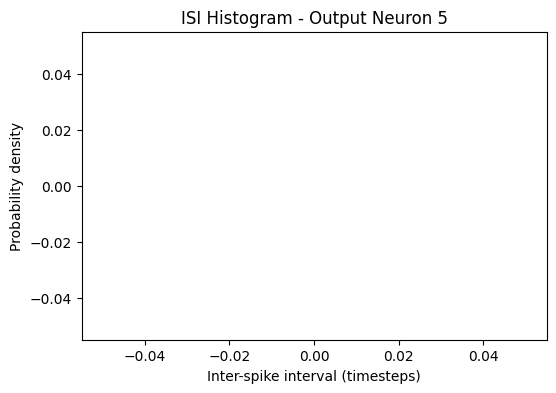

In [72]:
snn_param_dir = 'save_models/snn_bptt_mnist_train.p'
snn_param_dict = pickle.load(open(snn_param_dir, 'rb'))
input_2_hidden_weight = snn_param_dict['weight1']
hidden_2_output_weight = snn_param_dict['weight2']

vdecay = 0.75
vth = 0.5
nn = SNN(input_2_hidden_weight, hidden_2_output_weight, 784, 256, 10, vdecay, vth, 20)

test_image_list, test_label_list = read_numpy_mnist_data('data/mnist_test', 20)
test_event_image_list = img_2_event_img(corrupt_gaussian_mnist(test_image_list, severity=1), nn.snn_timestep)

sample_idx = 12
plt.figure()
plt.imshow(test_event_image_list[sample_idx][:, :, 0], cmap='gray')
plt.title(f"Original MNIST Image (Label={test_label_list[sample_idx]})")
plt.show()

x = test_event_image_list[sample_idx].reshape(-1, nn.snn_timestep)
x = x.T

T = nn.snn_timestep
hidden_dim = nn.hiddenLayer.dimension
output_dim = nn.outputLayer.dimension

H_raster = np.zeros((hidden_dim, T))
O_raster = np.zeros((output_dim, T))
spike_output = np.zeros(output_dim)

for t in range(T):
    x_t = x[t]
    h_t = nn.connection1(x_t)
    hidden_spikes = nn.hiddenLayer(h_t)
    H_raster[:, t] = hidden_spikes
    o_t = nn.connection2(hidden_spikes)
    output_spikes = nn.outputLayer(o_t)
    O_raster[:, t] = output_spikes
    spike_output += output_spikes

fig, ax = plt.subplots(figsize=(10,5))
raster(ax, H_raster, "Hidden Layer Raster")
plt.show()

neuron_spike_counts = H_raster.sum(axis=1)
median_neuron_idx = np.argsort(neuron_spike_counts)[len(neuron_spike_counts)//2]
median_neuron_isis = isi_from_times(spike_times_from_train(H_raster[median_neuron_idx]))
plt.figure(figsize=(6,4))
plt.hist(median_neuron_isis, bins=50, density=True)
plt.xlabel("Inter-spike interval (timesteps)")
plt.ylabel("Probability density")
plt.title(f"ISI Histogram - Hidden Neuron {median_neuron_idx}")
plt.show()

all_hidden_isis = pooled_hidden_isis(H_raster)
plt.figure(figsize=(6,4))
plt.hist(all_hidden_isis, bins=50, density=True)
plt.xlabel("Inter-spike interval (timesteps)")
plt.ylabel("Probability density")
plt.title("Pooled Hidden Layer ISI Histogram")
plt.show()

fig, ax = plt.subplots(figsize=(10,5))
raster(ax, O_raster, "Output Layer Raster")
plt.show()

output_spike_counts = O_raster.sum(axis=1)
median_output_idx = np.argsort(output_spike_counts)[len(output_spike_counts)//2]
median_output_isis = isi_from_times(spike_times_from_train(O_raster[median_output_idx]))
plt.figure(figsize=(6,4))
plt.hist(median_output_isis, bins=50, density=True)
plt.xlabel("Inter-spike interval (timesteps)")
plt.ylabel("Probability density")
plt.title(f"ISI Histogram - Output Neuron {median_output_idx}")
plt.show()

Refer to the example output below:

![Example.png](Example.png)

<font color='red'>

Answer 6e.

# Q7: How input statistics shape population dynamics

Now you’ll drive your SNN with five synthetic input patterns: Poisson, periodic, bursty, rate-modulated Poisson, and correlated Poisson. Using the plots from question 6 you will visualize how each pattern propagates through the network. For every pattern you will generate:

* Rasters (hidden & output): time-resolved spiking across neurons

* PSTHs (hidden & output): population activity per timestep

* Gaussian-smoothed population rates (hidden & output)

* ISI histograms (pooled hidden)

Your goal is to recognize the statistical fingerprint of each input by comparing these plots and explaining how input regularity, bursts, rate changes, and shared correlations reshape population dynamics and the readout layer.

Why this matters: Real neural populations are driven by inputs with different statistics (steady, rhythmic, bursty, synchronized). Being able to read plots and infer the underlying drive is a core skill in computational and systems neuroscience—and it helps you debug and tune SNNs.



Questions: 

For each input interpret and describe the visual differences between the plots (you should have a short description for each of the 5 inputs)


Compare between the input patterns:

* Periodic vs Poisson: Which plots most clearly distinguish them?

* You'll observe that both the bursty and rate-modulated patterns raise the mean firing rate at times. What features let you tell them apart?

* Independent Poisson vs correlated Poisson: Where do shared events show up most saliently—hidden raster, PSTH peaks, smoothed rate bumps, or pooled ISI mass at short intervals?

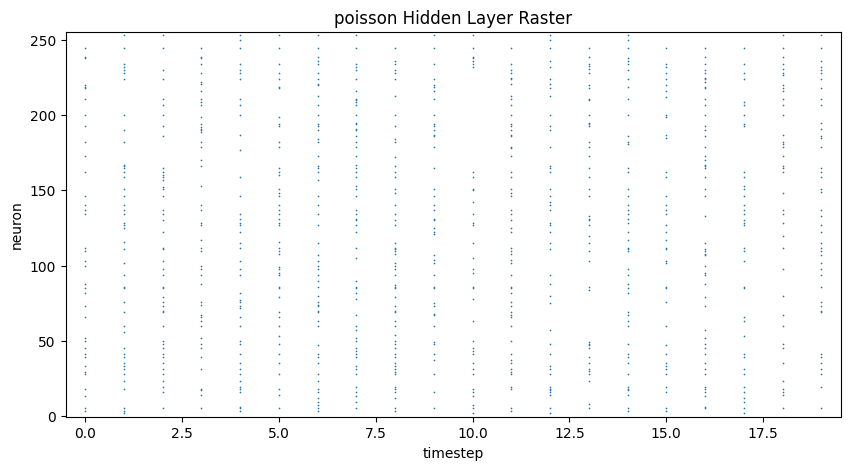

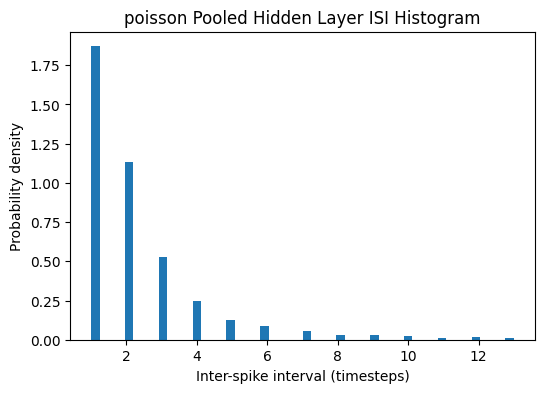

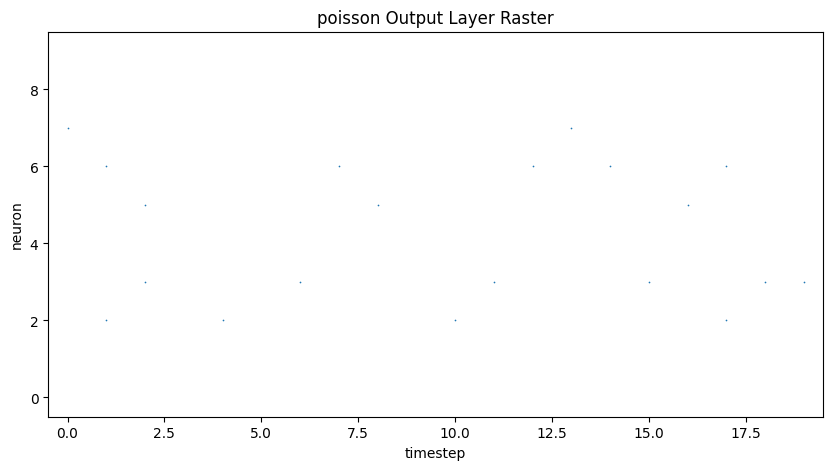

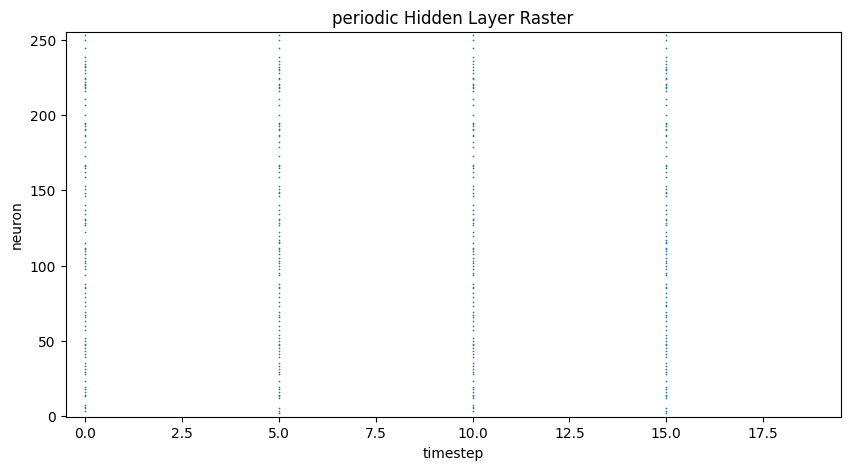

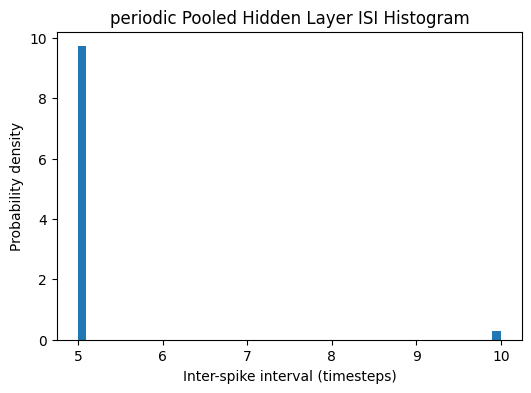

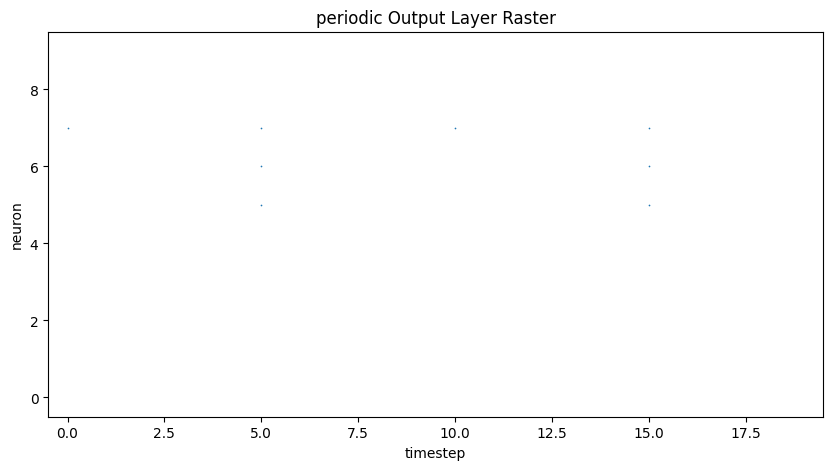

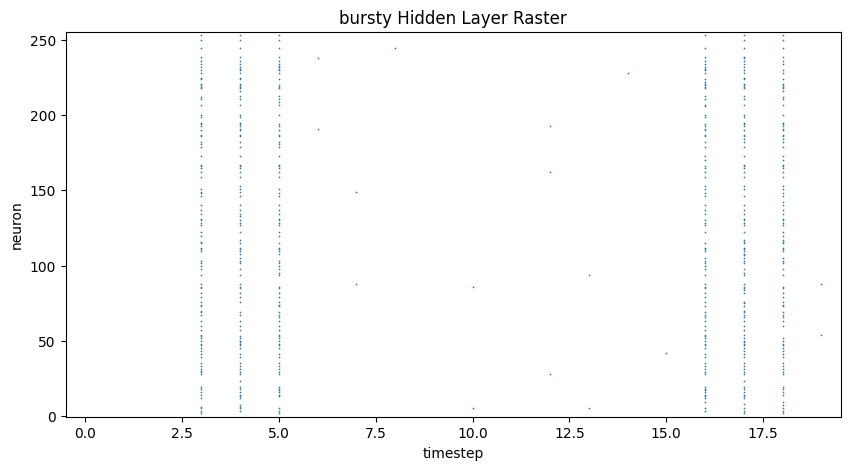

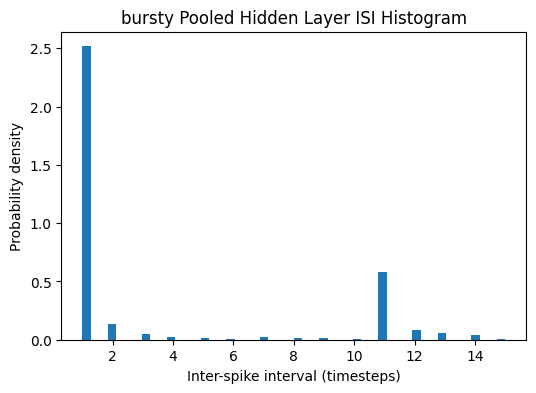

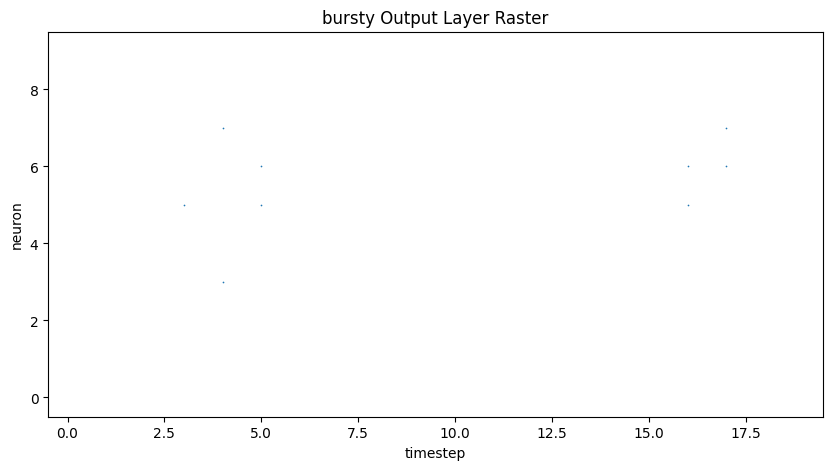

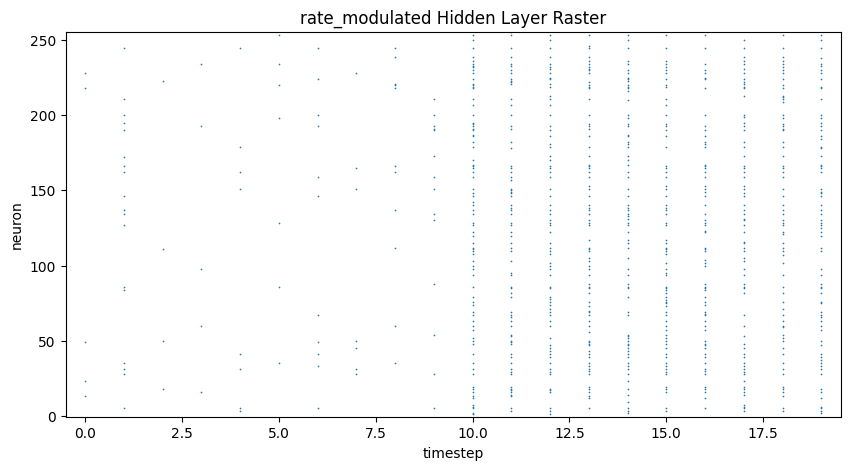

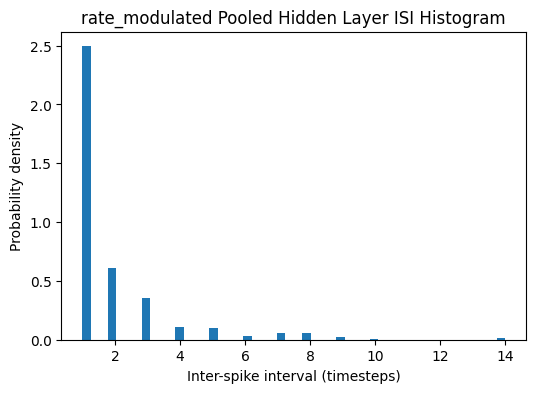

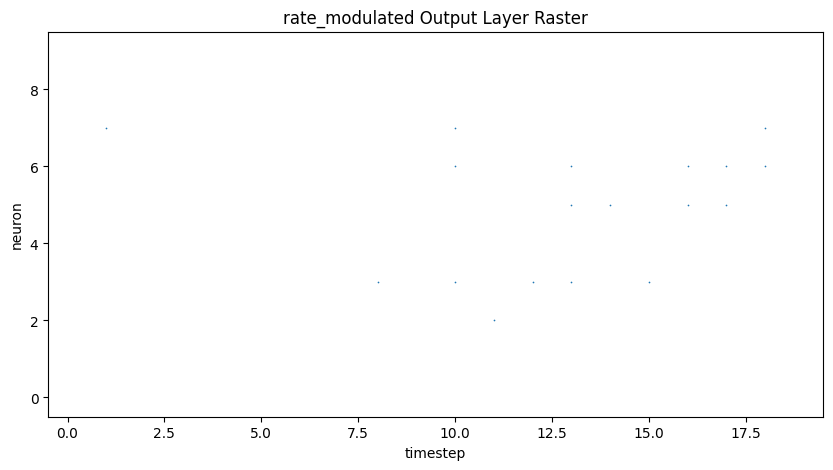

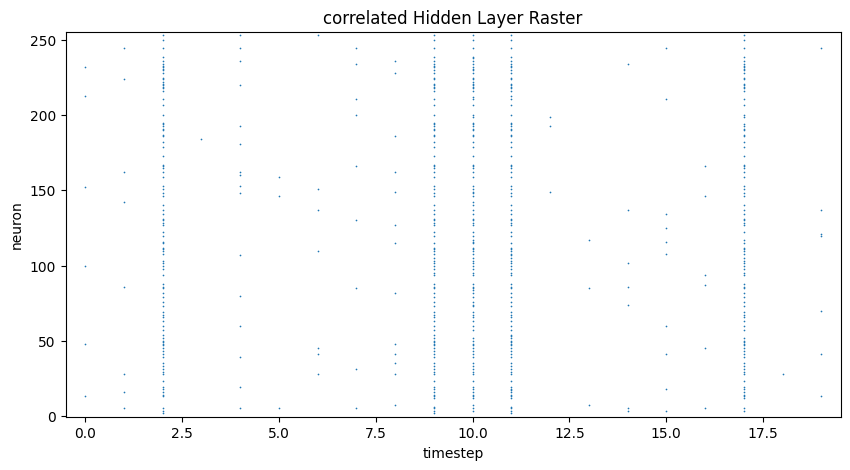

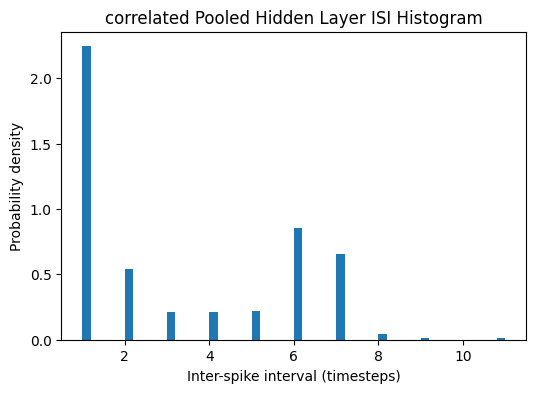

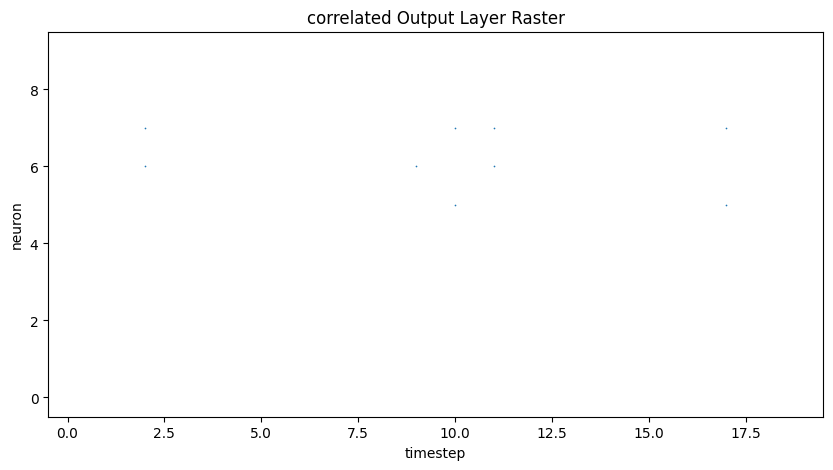

In [77]:
# ======== Input pattern generators, do NOT edit these functions ========
rng = np.random.default_rng(0)

def poisson_input(input_dim, T, rate=0.2, rng=rng):
    # rate is P(spike) per timestep per neuron
    return (rng.random((input_dim, T)) < rate).astype(float)

def periodic_input(input_dim, T, period=5, duty=1):
    # fire every 'period' steps; on for 'duty' steps each cycle
    S = np.zeros((input_dim, T))
    for t in range(0, T, period):
        S[:, t:t+duty] = 1.0
    return S

def bursty_input(input_dim, T, base_rate=0.02, burst_rate=0.8, burst_len=3, n_bursts=2, rng=rng):
    S = (rng.random((input_dim, T)) < base_rate).astype(float)
    # add a few random population bursts
    for _ in range(n_bursts):
        start = rng.integers(0, max(1, T - burst_len + 1))
        burst_block = (rng.random((input_dim, burst_len)) < burst_rate).astype(float)
        S[:, start:start+burst_len] = np.maximum(S[:, start:start+burst_len], burst_block)
    return S

def rate_modulated_poisson(input_dim, T, low=0.05, high=0.35, split=None, rng=rng):
    if split is None:
        split = T // 2
    S = np.zeros((input_dim, T))
    S[:, :split] = (rng.random((input_dim, split)) < low).astype(float)
    S[:, split:] = (rng.random((input_dim, T - split)) < high).astype(float)
    return S

def correlated_poisson(input_dim, T, shared_rate=0.15, private_rate=0.05, rng=rng):
    # shared population drive + independent private spikes
    shared = (rng.random(T) < shared_rate).astype(float)  # (T,)
    private = (rng.random((input_dim, T)) < private_rate).astype(float)
    S = private.copy()
    # add shared spikes to all inputs at the same timesteps
    S[:, shared > 0] = 1.0
    return S

# ======== Run & visualize for each pattern ========
patterns = {
    "poisson": poisson_input,
    "periodic": periodic_input,
    "bursty": bursty_input,
    "rate_modulated": rate_modulated_poisson,
    "correlated": correlated_poisson
}


for name, gen in patterns.items():
    rng = np.random.default_rng(0)

patterns = {
    "poisson": poisson_input,
    "periodic": periodic_input,
    "bursty": bursty_input,
    "rate_modulated": rate_modulated_poisson,
    "correlated": correlated_poisson
}

input_dim = nn.inputLayer.dimension
T = nn.snn_timestep
hidden_dim = nn.hiddenLayer.dimension
output_dim = nn.outputLayer.dimension

for name, gen in patterns.items():
    S_input = gen(input_dim, T)
    H_raster = np.zeros((hidden_dim, T))
    O_raster = np.zeros((output_dim, T))
    spike_output = np.zeros(output_dim)
    for t in range(T):
        x_t = S_input[:, t]
        h_t = nn.connection1(x_t)
        hidden_spikes = nn.hiddenLayer(h_t)
        H_raster[:, t] = hidden_spikes
        o_t = nn.connection2(hidden_spikes)
        output_spikes = nn.outputLayer(o_t)
        O_raster[:, t] = output_spikes
        spike_output += output_spikes

    fig, ax = plt.subplots(figsize=(10,5))
    raster(ax, H_raster, f"{name} Hidden Layer Raster")
    plt.show()

    all_hidden_isis = pooled_hidden_isis(H_raster)
    plt.figure(figsize=(6,4))
    plt.hist(all_hidden_isis, bins=50, density=True)
    plt.xlabel("Inter-spike interval (timesteps)")
    plt.ylabel("Probability density")
    plt.title(f"{name} Pooled Hidden Layer ISI Histogram")
    plt.show()

    fig, ax = plt.subplots(figsize=(10,5))
    raster(ax, O_raster, f"{name} Output Layer Raster")
    plt.show()




<font color='red'>

answer q7.

# Question 8: Local Field Potential (LFP) & Power Spectra of Network Activity

In neuroscience, local field potentials (LFPs) are one of the most important signals we record when studying brain activity — they capture the collective electrical behavior of neurons in a local region of tissue rather than the action potentials (spikes) of individual neurons. An LFP is the low-frequency component (typically <250 Hz) of the voltage recorded by an extracellular electrode.
It reflects the summed transmembrane currents (mainly synaptic input currents and other slow ionic processes) occurring within roughly a few hundred micrometers of the electrode tip.

When you record from a probe like Neuropixels or Utah arrays, you pick up a raw extracellular voltage that’s a mixture of:
* Fast, high-frequency activity (300–5000 Hz): dominated by brief action potentials from nearby neurons and usually isolated by high-pass filtering, producing spike trains.

* Slow, low-frequency activity (0.1–250 Hz): dominated by synchronized synaptic currents, dendritic activity, and population oscillations usuaally isolated by low-pass filtering, producing the LFP.

Thus, the LFP is not about what a single neuron is firing, but rather how the population of neurons and their inputs are behaving together. Spikes tell you what specific neurons are doing; LFPs tell you how entire circuits are oscillating or communicating.
For example, you can track theta, beta, or gamma rhythms to understand attention, movement preparation, or memory processes. LFPs are essential for studying functional coupling between regions (e.g., phase coherence between motor cortex and striatum) as these relationships are invisible in spike-only analyses. Because they reflect averaged currents, LFPs are less noisy and more stable over time than single-unit activity, which can vary due to electrode drift or neuron loss. Many behaviors (e.g., decision making, motor planning, sleep states) are reflected in distinct band power patterns such as increased beta during movement suppression or theta during navigation.


In this question you will (i) construct an LFP-like signal from your SNN, (ii) examine its time and frequency-domain behavior alongside population firing rate, and (iii) analyze its frequency content with a power spectrum and band powers. You’ll perform these analyses for the poisson input pattern (reuse your generators from Q7) so you can connect input statistics → population spiking → LFP rhythms.

LFP proxy (for this assignment):
At each timestep t, define the layer LFP as the mean postsynaptic current into that layer: 

$LFP_{H}(t) = mean(input2hiddenpsp(t))$, $LFP_{O}(t) = mean(hidden2outputpsp(t))$. Then apply a zero-mean Gaussian low-pass filter (use your Q6 smoothing helper) before plotting/analyzing.

Important: For frequency analysis you need sufficient duration. Use T≥200 timesteps (e.g., set snn_timestep=200 or more for a separate snn_long object defined using the same snn parameters as your solution to 5b).

## 8a. Record PSP and build LFP traces

Extend your recorder from question 6 so it returns both spikes and PSPs each timestep, then derive LFPs.

Return:
H, O (spikes; shapes: hidden_dim × T, output_dim × T)
H_psp_all, O_psp_all (PSPs; same shapes)
LFP_H, LFP_O (means over neurons; shape: T,), unsmoothed

Smooth each LFP with a Gaussian (e.g., $\sigma_{lp}=2–4$ timesteps)

In [ ]:
# ==== Recorder with PSP capture & LFP computation ====
def run_snn_collect_with_psp(network, spike_encoding):
    """
    Returns:
      H, O: spike matrices (hidden_dim x T), (output_dim x T)
      H_psp_all, O_psp_all: PSP matrices (hidden_dim x T), (output_dim x T)
      LFP_H, LFP_O: mean PSP per timestep (T,), unsmoothed
    """
    T = network.snn_timestep
    H = np.zeros((network.hidden_layer.dimension, T))
    O = np.zeros((network.output_layer.dimension, T))
    H_psp_all = np.zeros_like(H)
    O_psp_all = np.zeros_like(O)

    # reset states
    for lyr in (network.hidden_layer, network.output_layer):
        lyr.volt[:] = 0.0
        lyr.spike[:] = 0.0

    for tt in range(T):
        h_psp =                     # (hidden_dim,)
        h_spk = 
        o_psp =                     # (output_dim,)
        o_spk = 

        H[:, tt] = h_spk
        O[:, tt] = o_spk
        H_psp_all[:, tt] = h_psp
        O_psp_all[:, tt] = o_psp

    LFP_H = 
    LFP_O = 
    return H, O, H_psp_all, O_psp_all, LFP_H, LFP_O

## 8b. Time-domain plots

Plot the smoothed LFP for Hidden and Output (separate figures).

Plot the smoothed population firing rate (from Q6e) for the same layer(s) on separate figures.

Question: Briefly describe how LFP covaries with spikes

In [ ]:
# ==== Time-domain plotting ====
def plot_lfp_and_rate(LFP, S, sigma_lp=3.0, title_prefix='Hidden', Fs=100.0):
    LFP_s = gaussian_smooth_1d(LFP, sigma=sigma_lp)
    rate = population_rate(S, dt=1.0)                   # spikes/neuron/bin
    rate_s = gaussian_smooth_1d(rate, sigma=1.0)        # reuse small sigma for rate

    t = np.arange(LFP.size) / Fs

    # LFP plot

    # Rate plot
    

<font color='red'>

answer 8b.

## 8c. Frequency-domain analysis & band powers

Choose a nominal sampling rate $F_{S}$ that maps timesteps to seconds (e.g., $F_{S} = 100Hz$​ ⇒ one timestep = 10 ms). Compute the one-sided power spectrum of each (smoothed) LFP: $P(f)=\frac{|rfft(x-\bar{x})|^2}{T}$, where $f=rfftfreq(T, 1/F_{S})$ and $rfft()$ is the real-valued fast fourier transform.

Plot Power vs Frequency (Hz) for Hidden and Output LFP.
Compute band powers by summing spectral power in canonical bands (adjust if your $F_{S}$ differs):
* δ: 1–4 Hz,
* θ: 4–8 Hz,
* α: 8–12 Hz,
* β: 12–30 Hz,
* γ: 30–45 Hz

Due to complexity of this operation, we provide functions below that already compute each of these components of the LFP analysis. Do not change the functions below, your job is to simply use them to produce the correct plots and interpret

In [ ]:
# ==== Frequency-domain & band powers ====
def power_spectrum_onesided(x, Fs):
    """
    x: (T,) 1D signal
    returns freqs (Hz), power
    """
    x = x - x.mean()
    T = x.size
    X = np.fft.rfft(x)
    P = (np.abs(X)**2) / T
    freqs = np.fft.rfftfreq(T, d=1.0/Fs)
    return freqs, P

def bandpower(freqs, P, fmin, fmax):
    idx = (freqs >= fmin) & (freqs < fmax)
    return P[idx].sum()

def plot_spectrum(freqs, P, title):
    plt.figure(figsize=(6,3))
    plt.plot(freqs, P)
    plt.xlim(0, freqs.max())
    plt.xlabel('Frequency (Hz)'); plt.ylabel('Power')
    plt.title(title)
    plt.tight_layout(); plt.show()

def report_bands(freqs, P, Fs=100.0):
    bands = {
        'delta (1-4 Hz)': (1, 4),
        'theta (4-8 Hz)': (4, 8),
        'alpha (8-12 Hz)': (8, 12),
        'beta (12-30 Hz)': (12, 30),
        'gamma (30-45 Hz)': (30, 45),
    }
    out = {}
    for name, (f1, f2) in bands.items():
        out[name] = bandpower(freqs, P, f1, f2)
    return out

In [ ]:
# ==== Frequency-domain visuals: band traces + spectrogram ====

def _bands_to_list(bands):
    """Accepts either a dict {'name': (f1,f2)} or a list of (name,f1,f2). Returns list."""
    if isinstance(bands, dict):
        return [(k, v[0], v[1]) for k, v in bands.items()]
    return bands

def fir_bandpass(signal, Fs, f_lo, f_hi, numtaps=401, eps=1e-12):
    """
    Windowed-sinc FIR bandpass with Hamming window (NumPy-only).
    Ensures numtaps is odd and < len(signal).
    """
    import numpy as np
    x = np.asarray(signal, float)
    T = x.size

    M = int(numtaps)
    if M >= T:
        M = max(51, (T // 2) | 1)  # ≈T/2, at least 51, force odd
    if M % 2 == 0:
        M += 1

    nyq = Fs / 2.0
    fl = max(eps, f_lo / nyq)
    fh = min(1.0 - eps, f_hi / nyq)

    n = np.arange(M) - (M - 1) / 2.0
    def sinc(z):
        out = np.ones_like(z)
        nz = z != 0
        out[nz] = np.sin(np.pi * z[nz]) / (np.pi * z[nz])
        return out

    h_fh = 2 * fh * sinc(2 * fh * n)
    h_fl = 2 * fl * sinc(2 * fl * n)
    h = h_fh - h_fl

    w = 0.54 - 0.46 * np.cos(2 * np.pi * np.arange(M) / (M - 1))
    h *= w
    h /= h.sum() + 1e-12

    y = np.convolve(x, h, mode='same')
    y = np.convolve(y[::-1], h, mode='same')[::-1]
    return y

def stft_power(x, Fs=100.0, win_len=256, hop=64):
    import numpy as np
    x = np.asarray(x, float)
    win = np.hanning(win_len)
    n_frames = 1 + max(0, (x.size - win_len)//hop)
    F = win_len//2 + 1
    Sxx = np.zeros((F, n_frames))
    times = np.zeros(n_frames)
    for k in range(n_frames):
        s = k*hop
        seg = x[s:s+win_len]
        if seg.size < win_len:
            seg = np.pad(seg, (0, win_len - seg.size))
        seg = (seg - seg.mean()) * win
        X = np.fft.rfft(seg)
        Sxx[:, k] = (np.abs(X)**2) / win_len
        times[k] = (s + win_len/2)/Fs
    freqs = np.fft.rfftfreq(win_len, d=1.0/Fs)
    return freqs, times, Sxx

def plot_band_traces(LFP, Fs=100.0, bands=None, fir_taps=401, zscore=True, title='Band-pass traces'):
    """
    Plots one time-series per band (delta/theta/alpha/beta/gamma).
    """
    import numpy as np
    import matplotlib.pyplot as plt

    if bands is None:
        bands = BANDS
    bands_list = _bands_to_list(bands)

    T = LFP.size
    t = np.arange(T) / Fs
    nrows = len(bands_list)
    fig, ax = plt.subplots(nrows, 1, figsize=(10, 2*nrows), sharex=True)
    if nrows == 1:
        ax = [ax]

    for i, (label, f1, f2) in enumerate(bands_list):
        y = fir_bandpass(LFP, Fs, f1, f2, numtaps=fir_taps)
        if zscore:
            y = (y - y.mean()) / (y.std() + 1e-12)
        ax[i].plot(t, y, lw=0.9)
        ax[i].set_ylabel(label)
        ax[i].grid(False)

    ax[-1].set_xlabel('Time (s)')
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

def plot_spectrogram(LFP, Fs=100.0, win_len=256, hop=64, fmax=100.0, title='LFP Spectrogram'):
    """
    STFT power spectrogram up to fmax Hz.
    """
    import matplotlib.pyplot as plt
    freqs, times, Sxx = stft_power(LFP, Fs=Fs, win_len=win_len, hop=hop)
    fmask = freqs <= fmax
    plt.figure(figsize=(10, 3))
    im = plt.imshow(
        Sxx[fmask, :], origin='lower', aspect='auto',
        extent=[times[0], times[-1], freqs[fmask][0], freqs[fmask][-1]]
    )
    plt.xlabel('Time (s)'); plt.ylabel('Hz'); plt.title(title)
    cbar = plt.colorbar(im)
    cbar.set_label('Power (a.u.)')
    plt.tight_layout()
    plt.show()


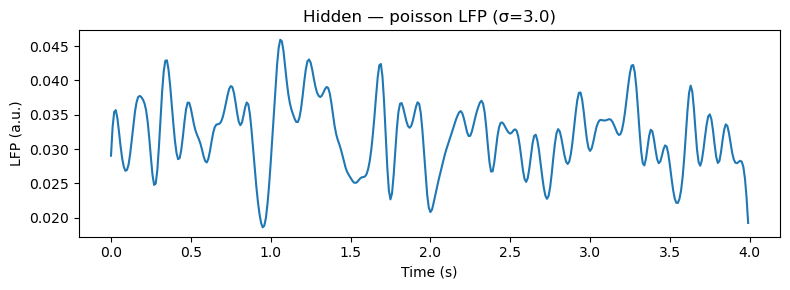

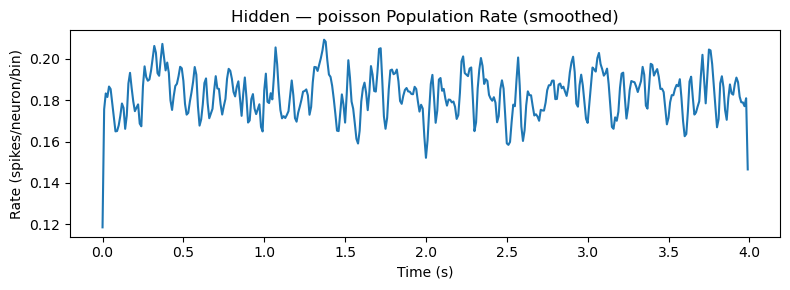

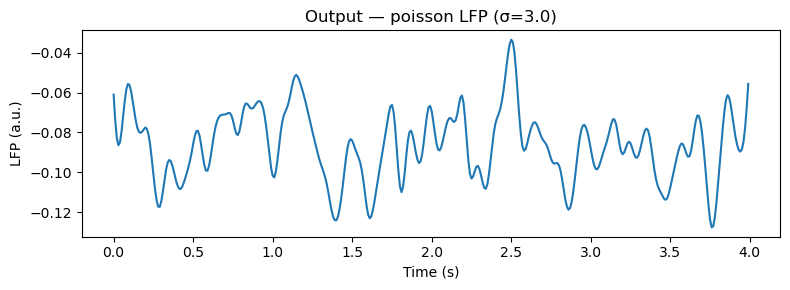

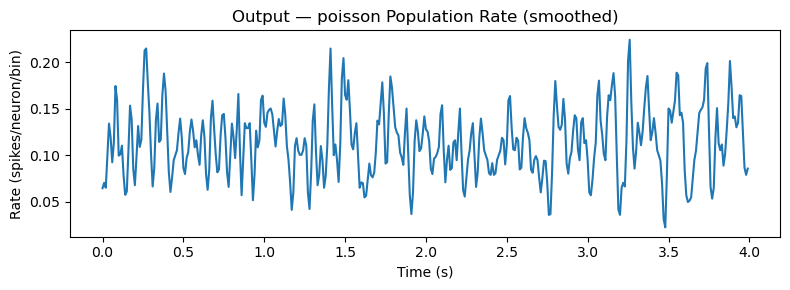

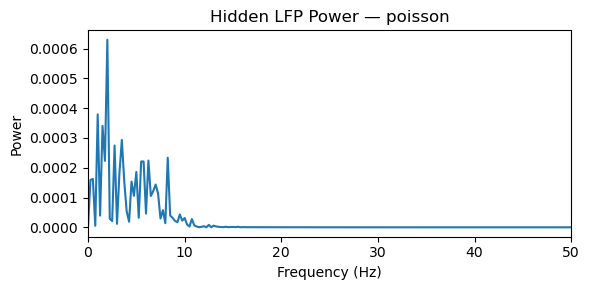

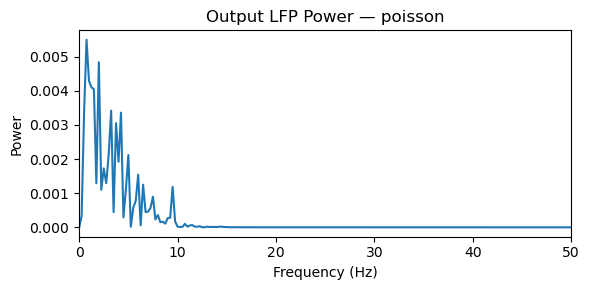

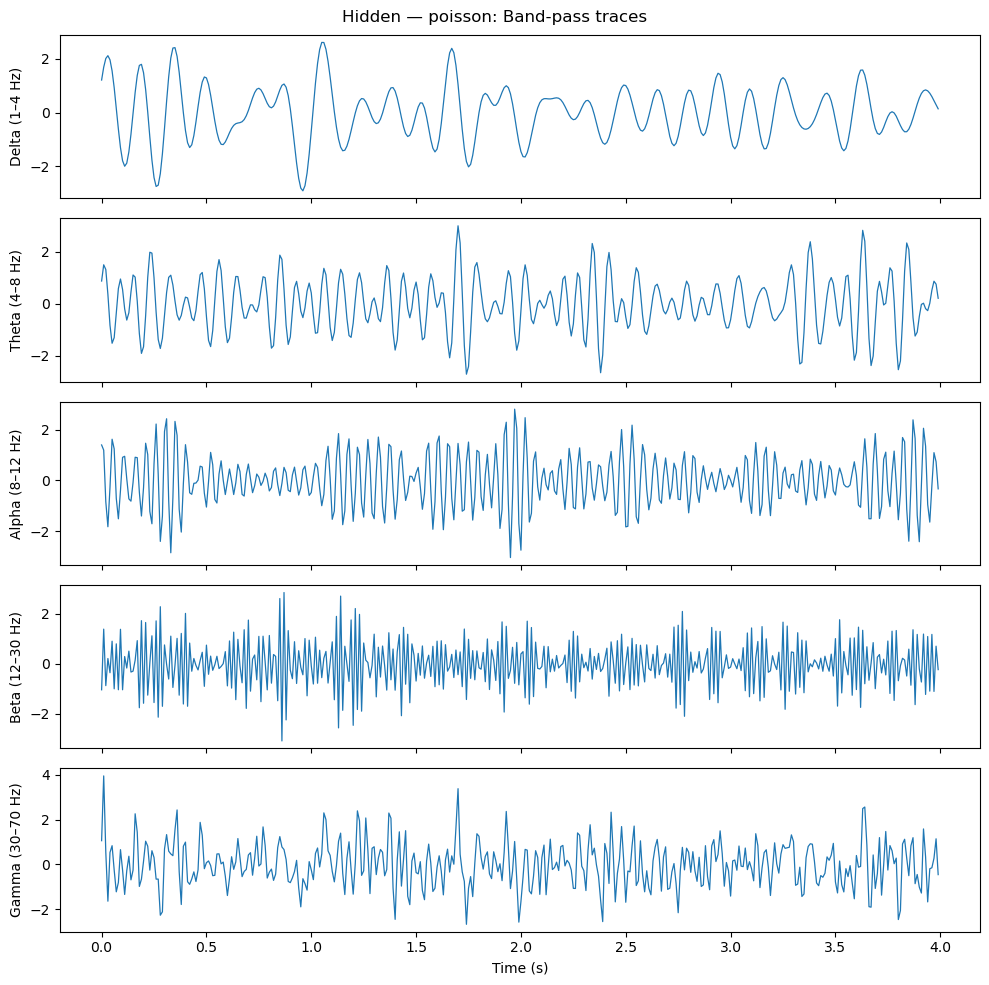

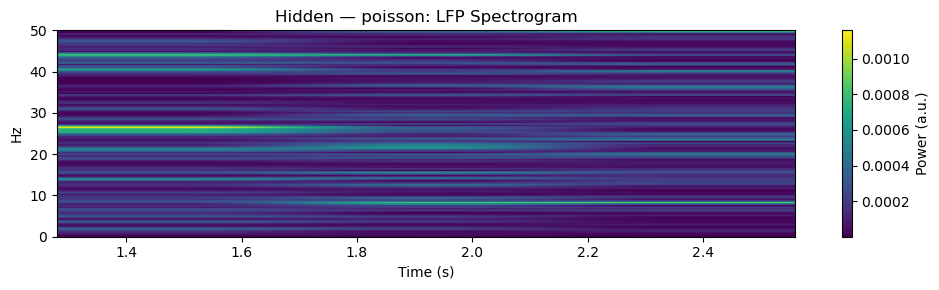

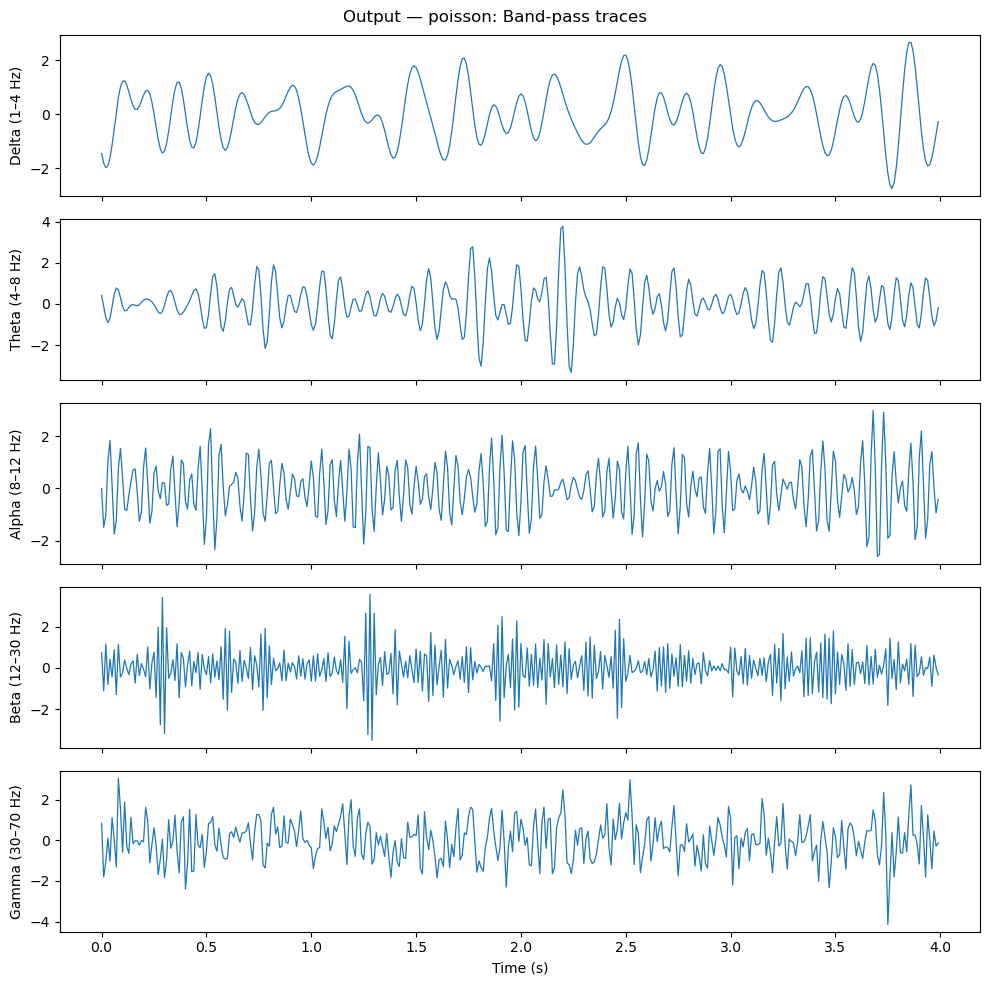

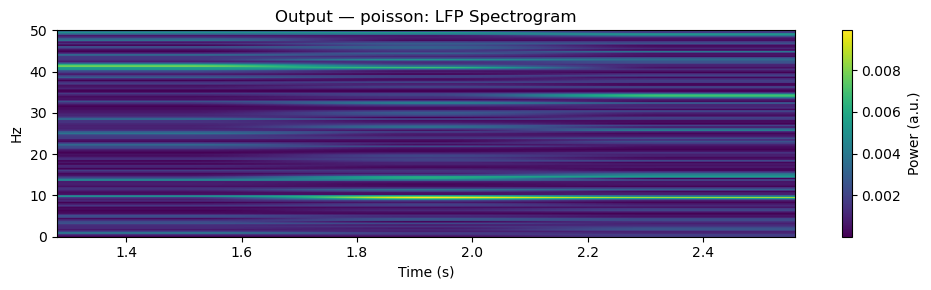

In [ ]:
# ====  Loop over patterns (reuse your Q7 generators) ====
snn_long = None #Todo: Implement

Fs = 100.0
T = snn_long.snn_timestep
sigma_lp = 3.0

for name, gen in patterns.items():
    S_in = gen(snn_long.input_2_hidden_connection.pre_dimension, T)
    H, O, Hpsp, Opsp, LFP_H, LFP_O = run_snn_collect_with_psp(snn_long, S_in)

    # Plot time domain

    # Plot frequency domain

    # Plot band traces and spectrogram 
    
    break #Plot only for the Poisson Input pattern (do not delete this line in your final submission but if you're curious what this looks like for all 5 input patterns, give it a whirl by commenting this out)


## 8d. 
In your LFP band analysis, each frequency range (delta, theta, alpha, beta, gamma) reflects different timescales of neural population activity. If your smoothed LFP and spectrogram show that most of the signal power is concentrated in the theta band (4–8 Hz) during the task, what does this suggest about the network’s temporal processing compared to one dominated by beta (12–30 Hz) or gamma (30–70 Hz) activity?

<font color='red'>


Answer 8d.